### drought index preparation

#### SSI

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


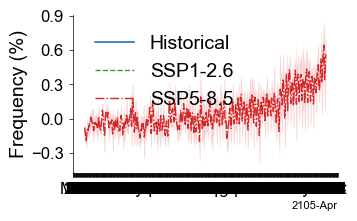

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import matplotlib as mpl
from pathlib import Path
import xarray as xr
from os.path import join
from tqdm.notebook import tqdm

def plot_drought_timeseries(historical, ssp126, ssp585, save_path=None):
    # 1. 设置图像尺寸
    fig_width_cm = 8.7
    fig_height_cm = fig_width_cm * 0.6
    plt.figure(figsize=(fig_width_cm/2.54, fig_height_cm/2.54))
    mpl.rcParams['pdf.fonttype'] = 42
    
    # 2. 字体设置
    plt.rcParams["font.family"] = "Arial"
    plt.rcParams["font.size"] = 8
    
    # 3. 坐标轴样式
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # 4. 计算滑动平均（窗口5年）
    def rolling_mean(series, window=5):
        return series.rolling(time=window, center=True, min_periods=1).mean()
    
    # 5. 绘制历史数据（使用max和min代替标准差）
    hist_mean = rolling_mean(historical['median'])
    ax.fill_between(historical['median'].time, 
                   rolling_mean(historical['min']).values,
                   rolling_mean(historical['max']).values,
                   color='#1f77b4', alpha=0.2, linewidth=0)
    hist_mean.plot(color='#1f77b4', linewidth=1.2, label='Historical')
    
    # 6. 绘制SSP1-2.6数据
    ssp126_mean = rolling_mean(ssp126['median'])
    ax.fill_between(ssp126['median'].time,
                   rolling_mean(ssp126['min']).values,
                   rolling_mean(ssp126['max']).values,
                   color='#2ca02c', alpha=0.2, linewidth=0)
    ssp126_mean.plot(color='#2ca02c', linestyle='--', linewidth=1.0, label='SSP1-2.6')
    
    # 7. 绘制SSP5-8.5数据
    ssp585_mean = rolling_mean(ssp585['median'])
    ax.fill_between(ssp585['median'].time,
                   rolling_mean(ssp585['min']).values,
                   rolling_mean(ssp585['max']).values,
                   color='#d62728', alpha=0.2, linewidth=0)
    ssp585_mean.plot(color='#d62728', linestyle='-.', linewidth=1.0, label='SSP5-8.5')
    
    # 8. 坐标轴和标签设置
    ax.set_xlim(1900, 2100)
    ax.set_ylabel('Frequency (%)', fontsize=14, labelpad=2)
    ax.set_xlabel('', fontsize=9, labelpad=2)
    
    # 9. 刻度设置
    ax.xaxis.set_major_locator(mticker.MultipleLocator(50))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
    ax.tick_params(axis='both', which='major', width=0.5, length=3, labelsize=12)
    
    # 10. 图例设置
    ax.legend(frameon=False, fontsize=14, loc='upper left', bbox_to_anchor=(0.02, 0.98))
    
    # 11. 保存图像
    if save_path:
        plt.savefig(
            save_path,
            format='pdf',
            dpi=300,
            bbox_inches='tight',
            transparent=True
        )
    plt.show()
    plt.close()

# 主处理流程
crops = ['mai', 'wwh', 'soy']
ss = ['historical', 'ssp126', 'ssp585']
crop_dict = {}

for crop in tqdm(crops, desc='Processing crops'):
    crop_dict[crop] = {}
    
    for ssp in ss:
        crop_dict[crop][ssp] = {}
        
        # 加载季节和区域数据
        season = xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_planting_to_maturity_masks.nc').mask_planting_to_maturity
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        
        # 处理文件
        input_dir = Path(r'E:\ssi')
        pattern = f'SSI_{crop}_*_{ssp}_*_kde.nc'
        files = list(input_dir.glob(pattern))
        
        model_data = []
        for file in tqdm(files, leave=False):
            # 特殊处理wwh作物
            if crop == 'wwh':
                wwh_data = xr.open_dataset(file).ssi.fillna(0)
                swh_file = str(file).replace("wwh", "swh")
                if Path(swh_file).exists():
                    swh_data = xr.open_dataset(swh_file).ssi.fillna(0)
                    combined = wwh_data + swh_data
                    combined = combined.where(combined != 0)
                    model_data.append(combined.mean(dim=['lat', 'lon']))
            else:
                data = xr.open_dataset(file).ssi
                model_data.append(data.mean(dim=['lat', 'lon']))
        
        # 合并所有模型数据
        if model_data:
            combined_data = xr.concat(model_data, dim='model')
            crop_dict[crop][ssp]['median'] = combined_data.median(dim='model')
            crop_dict[crop][ssp]['max'] = combined_data.max(dim='model')
            crop_dict[crop][ssp]['min'] = combined_data.min(dim='model')
            
            # 绘制图表（仅对historical、ssp126、ssp585都有的作物）
            if all(s in crop_dict[crop] for s in ['historical', 'ssp126', 'ssp585']):
                plot_drought_timeseries(
                    crop_dict[crop]['historical'],
                    crop_dict[crop]['ssp126'],
                    crop_dict[crop]['ssp585'],
                    save_path=rf'D:\AAUDE\paper\paper8\framework\drought_frequency_{crop}.pdf'
                )

In [20]:
crop_dict[crop]['ssp126']

{'median': <xarray.DataArray 'ssi' (time: 1008)> Size: 4kB
 array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 8kB 2016-01-01 2016-02-01 ... 2099-12-01,
 'max': <xarray.DataArray 'ssi' (time: 1008)> Size: 4kB
 array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 8kB 2016-01-01 2016-02-01 ... 2099-12-01,
 'min': <xarray.DataArray 'ssi' (time: 1008)> Size: 4kB
 array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 8kB 2016-01-01 2016-02-01 ... 2099-12-01}

In [16]:
combined_data.median(dim='model')

<xarray.DataArray 'ssi' (time: 1020)> Size: 4kB
array([-0.05602652, -0.06752157, -0.20313308, ...,  0.6823646 ,
        0.63191855,  0.5108311 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8kB 2016-01-01 2016-02-01 ... 2100-12-01

In [6]:
import xarray as xr
import numpy as np
from pathlib import Path
from dask.distributed import Client, LocalCluster
from tqdm.notebook import tqdm
import gc
from scipy.stats import norm
import os
import warnings
from os.path import join
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
crop='mai';ssp='ssp585'
input_dir = Path(r'E:\isimip3b_agricultal\soilmoist')
area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

season_fut = xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_planting_to_maturity_masks.nc').mask_planting_to_maturity
season=season_fut
pattern = f'*{ssp}_2015soc_default_soilmoist-{crop}-noirr_*.nc'
files = list(input_dir.glob(pattern))
sm=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\resu\soilmoist_{crop}_{ssp}_median.nc')['soilmoist-mai-noirr']
sm['time']=season.time.values
sm=sm.where(season&(area>0))

In [ ]:
crops = ['mai', 'swh','wwh', 'soy']
ss=['historical','ssp126','ssp585']
for crop in tqdm(crops, desc='Processing crops'):

In [59]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import norm
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

# 核心参数：3个月时间尺度（对应论文中SSI的3个月尺度定义{insert\_element\_1\_}）
scale = 3

# 1. 数据预处理（确保时间连续，便于滑动窗口计算）
sm = sm.sortby('time')  # 按时间排序
time = sm.time.values
n_time = len(time)

# 2. 生成3个月滑动窗口索引（每个窗口包含连续3个月数据）
window_indices = [np.arange(i, i + scale) for i in range(n_time - scale + 1)]

# 3. 初始化SSI结果（维度：(window, lat, lon)，对应3个月窗口的结果）
ssi = xr.DataArray(
    np.full((len(window_indices), sm.shape[1], sm.shape[2]), np.nan),
    dims=['window', 'lat', 'lon'],
    coords={
        'window': [f'{time[i].strftime("%Y-%m")}_to_{time[i+scale-1].strftime("%Y-%m")}' 
                   for i in range(len(window_indices))],
        'lat': sm.lat,
        'lon': sm.lon
    },
    name='SSI'
)

# 4. 定义单个3个月窗口的SSI计算函数（遵循论文核密度+正态转换逻辑）
def calc_window_ssi(window_idx):
    # 提取当前3个月窗口的土壤湿度数据
    sm_window = sm.isel(time=window_indices[window_idx])
    sm_window_np = sm_window.values  # shape: (3, lat, lon)
    
    # 存储当前窗口的SSI结果
    ssi_window = np.full((sm.shape[1], sm.shape[2]), np.nan)
    
    # 遍历网格点计算
    for lat_idx in range(sm.shape[1]):
        for lon_idx in range(sm.shape[2]):
            # 提取该网格点3个月的土壤湿度（排除NaN）
            grid_vals = sm_window_np[:, lat_idx, lon_idx]
            grid_vals = grid_vals[~np.isnan(grid_vals)]
            if len(grid_vals) < scale:  # 至少需要3个有效数据（满足3个月尺度）
                continue
            
            # 核密度估计（论文核心步骤）
            bandwidth = 1.06 * np.std(grid_vals) * (len(grid_vals) **(-1/5))  # 带宽估计
            
            # 计算窗口内均值的SSI（代表该3个月的整体干旱状况）
            window_mean = np.mean(grid_vals)
            cdf = np.mean(norm.cdf((window_mean - grid_vals) / bandwidth))  # 累积分布函数
            ssi_window[lat_idx, lon_idx] = norm.ppf(cdf)  # 正态分位数转换
    
    return ssi_window

# 5. 并行计算所有3个月窗口的SSI
ssi_results = Parallel(n_jobs=-1, verbose=10)(
    delayed(calc_window_ssi)(idx) for idx in range(len(window_indices))
)

# 6. 赋值结果并添加属性（关联论文方法）
ssi.values = np.array(ssi_results)
# ssi.attrs['scale'] = f'{scale}个月（对应论文中3个月尺度SSI定义{insert\_element\_2\_}）'
# ssi.attrs['method'] = '核密度估计+正态分位数转换（基于目标文件方法）'

# 7. 保存结果
# output_path = r'D:\sm_ssi_scale3.nc'
ssi.to_netcdf(output_path)
print(f"3个月尺度SSI计算完成，已保存至：{output_path}")

AttributeError: 'numpy.datetime64' object has no attribute 'strftime'

In [51]:
import xarray as xr
import numpy as np
import pandas as pd  # 用于时间格式转换
from scipy.stats import norm
from joblib import Parallel, delayed
from pathlib import Path
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

def calculate_ssi_scale3(sm, crop, ssp):
    """
    计算3个月尺度SSI（基于目标文件方法，修正时间格式处理错误）
    """
    # 1. 数据预处理（确保时间连续，按3个月窗口划分）
    sm = sm.sortby('time')
    time = sm.time.values  # numpy.datetime64数组
    n_time = len(time)
    scale = 3  # 3个月尺度
    valid_windows = np.arange(n_time - scale + 1)
    if len(valid_windows) == 0:
        raise ValueError("数据时间长度不足3个月，无法计算3个月尺度SSI")

    # 2. 初始化SSI结果（修正时间标签格式）
    # 将numpy.datetime64转换为pandas datetime以使用strftime
    time_pd = pd.to_datetime(time)
    ssi = xr.DataArray(
        np.full((len(valid_windows), sm.shape[1], sm.shape[2]), np.nan),
        dims=['window', 'lat', 'lon'],
        coords={
            # 使用pandas datetime处理格式
            'window': [f'{time_pd[i].strftime("%Y-%m")}_to_{time_pd[i+scale-1].strftime("%Y-%m")}' 
                       for i in valid_windows],
            'lat': sm.lat,
            'lon': sm.lon
        },
        name='ssi'
    )

    # 3. 定义窗口内SSI计算函数（遵循目标文件核密度估计逻辑）
    def calc_window_ssi(window_idx):
        start = window_idx
        end = start + scale
        sm_window = sm.isel(time=slice(start, end))
        sm_window_np = sm_window.values
        
        ssi_window = np.full((sm.shape[1], sm.shape[2]), np.nan)
        for lat_idx in range(sm.shape[1]):
            for lon_idx in range(sm.shape[2]):
                grid_vals = sm_window_np[:, lat_idx, lon_idx]
                valid_vals = grid_vals[~np.isnan(grid_vals)]
                if len(valid_vals) < scale:
                    continue
                
                # 核密度估计（目标文件核心步骤）
                bandwidth = 1.06 * np.std(valid_vals) * (len(valid_vals) **(-1/5))
                window_mean = np.mean(valid_vals)
                cdf = np.mean(norm.cdf((window_mean - valid_vals) / bandwidth))
                ssi_window[lat_idx, lon_idx] = norm.ppf(cdf)
        return ssi_window

    # 4. 并行计算
    ssi_results = Parallel(n_jobs=-1, verbose=0)(
        delayed(calc_window_ssi)(idx) for idx in tqdm(valid_windows, desc="计算3个月尺度SSI")
    )
    ssi.values = np.array(ssi_results)

    # 5. 保存结果
    ssi.attrs['scale'] = f"{scale}个月（符合目标文件时间尺度设定）"
    ssi.attrs['method'] = "核密度估计+正态分位数转换（参考目标文件方法）"
    save_dir = Path(rf'D:\AAUDE\paper\paper8\data\ssi_v2')
    save_dir.mkdir(parents=True, exist_ok=True)
    save_path = save_dir / f'{crop}_{ssp}_ssi_scale3.nc'
    ssi.to_netcdf(save_path)
    print(f"3个月尺度SSI计算完成，已保存至：{save_path}")
    return ssi

# 使用示例
ssi_scale3 = calculate_ssi_scale3(sm, crop, ssp)

计算3个月尺度SSI:   0%|          | 0/1978 [00:00<?, ?it/s]

3个月尺度SSI计算完成，已保存至：D:\AAUDE\paper\paper8\data\ssi_v2\mai_historical_ssi_scale3.nc


In [48]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import norm
from joblib import Parallel, delayed
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
def calculate(sm,crop,ssi):
    # 1. 提取基础信息
    time = sm.time.values
    months = np.array([pd.to_datetime(t).month for t in time])
    unique_months = np.unique(months)
    lat_dim, lon_dim = sm.shape[1], sm.shape[2]  # 纬度、经度维度长度
    
    # 2. 定义单个网格点的SSI计算函数（核心，对应论文方法）
    def calc_grid_ssi(grid_ts, bandwidth):
        """计算单个网格点的SSI序列（输入：土壤湿度时间序列、带宽）"""
        ssi_ts = np.full_like(grid_ts, np.nan)
        for t_idx, x in enumerate(grid_ts):
            if np.isnan(x):
                continue
            # 核密度估计CDF + 正态分位数转换（论文核心步骤）
            cdf = np.mean(norm.cdf((x - grid_ts) / bandwidth))
            ssi_ts[t_idx] = norm.ppf(cdf)
        return ssi_ts
    
    # 3. 按月份并行计算（主要加速点）
    ssi = xr.full_like(sm, np.nan, dtype=np.float32)
    
    for month in tqdm(unique_months):
        # 提取该月份数据
        month_mask = (months == month)
        sm_month = sm.isel(time=month_mask)
        sm_month_np = sm_month.values  # shape: (time, lat, lon)
        
        # 并行处理每个网格点
        def process_lat(lat_idx):
            ssi_lat = np.full((sm_month.shape[0], lon_dim), np.nan)
            for lon_idx in range(lon_dim):
                grid_ts = sm_month_np[:, lat_idx, lon_idx]
                grid_ts = grid_ts[~np.isnan(grid_ts)]
                if len(grid_ts) < 5:  # 样本量过滤
                    continue
                # 带宽计算（论文交叉验证法简化为Silverman法则）
                bandwidth = 1.06 * np.std(grid_ts) * (len(grid_ts)** (-1/5))
                # 计算该网格点SSI
                ssi_lat[:, lon_idx] = calc_grid_ssi(sm_month_np[:, lat_idx, lon_idx], bandwidth)
            return ssi_lat
        
        # 多进程并行（根据CPU核心数调整n_jobs）
        ssi_month_np = Parallel(n_jobs=-1, verbose=0)(delayed(process_lat)(lat_idx) for lat_idx in range(lat_dim))
        ssi_month_np = np.array(ssi_month_np).transpose(1, 0, 2)  # 转换为(time, lat, lon)
        
        # 赋值到结果
        ssi.values[month_mask, :, :] = ssi_month_np
    
    # 4. 保存结果
    ssi = ssi.rename('ssi')
    ssi.to_netcdf(rf'D:\AAUDE\paper\paper8\data\ssi_v2\{crop}_{ssp}_ssi.nc')
# print("计算完成，结果已保存")

In [33]:
scale2_result.sel(time=slice("2019-01-01", None))

<xarray.DataArray 'ssi' (time: 984, lat: 360, lon: 720)> Size: 1GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * time     (time) datetime64[ns] 8kB 2019-01-01 2019-02-01 ... 2100-12-01

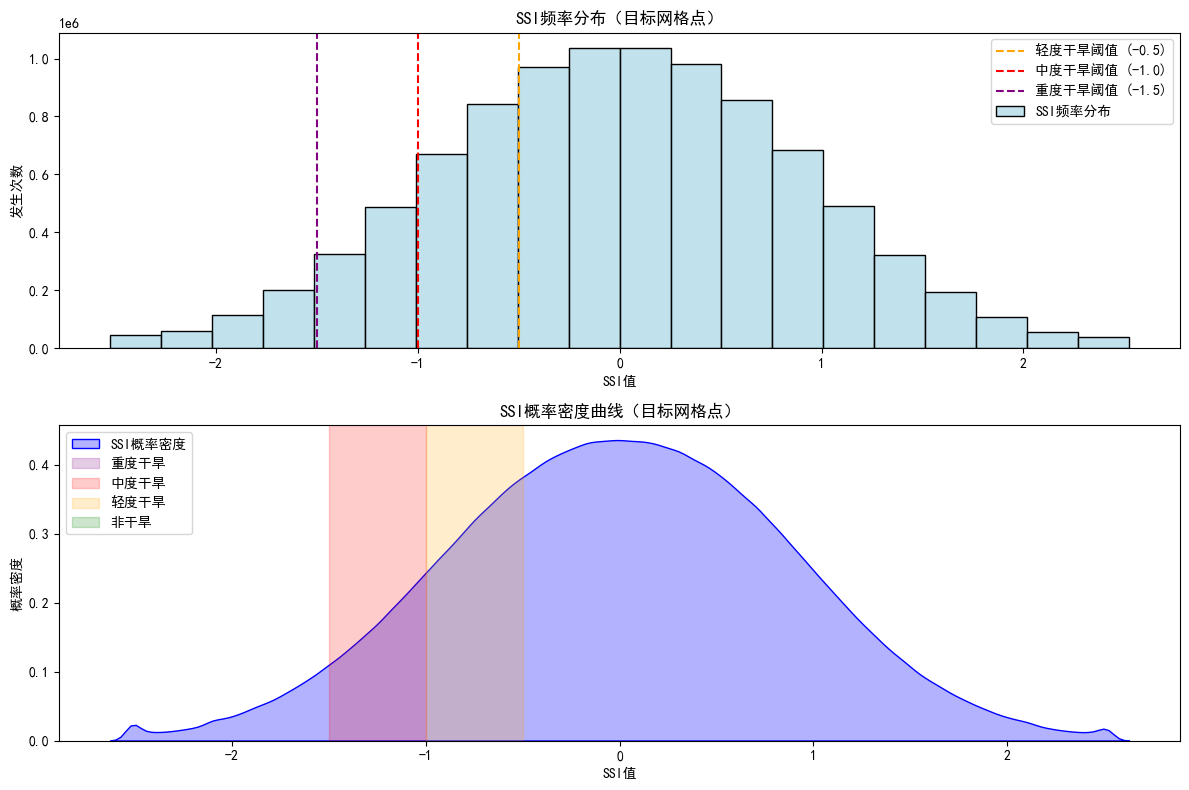

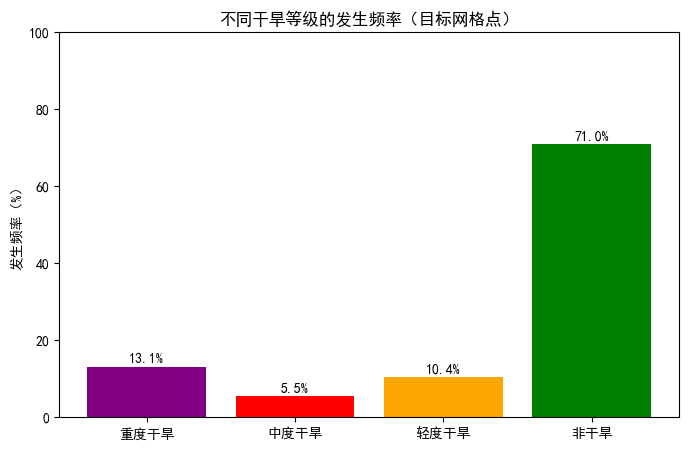

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# 指定默认字体
matplotlib.rcParams['font.family'] = 'SimHei' #或其他支持中文的字体
matplotlib.rcParams['axes.unicode_minus'] = False #解决负号'-'显示为方块的问题
# aa=xr.open_dataset(r"D:\AAUDE\paper\paper8\data\resu\ssi_scale2_mai_Historical_median.nc").ssi
ssi_data = scale2_result.values  # 提取SSI数值
ssi_valid = ssi_data[~np.isnan(ssi_data)]  # 去除无效值

# 1. 频率分布直方图 + 概率密度曲线
plt.figure(figsize=(12, 8))

# 直方图（频率分布）
plt.subplot(2, 1, 1)
sns.histplot(ssi_valid, bins=20, kde=False, stat='count', 
             color='lightblue', edgecolor='black', label='SSI频率分布')
plt.axvline(x=-0.5, color='orange', linestyle='--', label='轻度干旱阈值 (-0.5)')
plt.axvline(x=-1.0, color='red', linestyle='--', label='中度干旱阈值 (-1.0)')
plt.axvline(x=-1.5, color='purple', linestyle='--', label='重度干旱阈值 (-1.5)')
plt.xlabel('SSI值')
plt.ylabel('发生次数')
plt.title('SSI频率分布（目标网格点）')
plt.legend()

# 概率密度曲线（核密度估计）
plt.subplot(2, 1, 2)
sns.kdeplot(ssi_valid, color='blue', fill=True, alpha=0.3, label='SSI概率密度')
# 标注干旱区间
plt.axvspan(-np.inf, -1.5, color='purple', alpha=0.2, label='重度干旱')
plt.axvspan(-1.5, -1.0, color='red', alpha=0.2, label='中度干旱')
plt.axvspan(-1.0, -0.5, color='orange', alpha=0.2, label='轻度干旱')
plt.axvspan(-0.5, np.inf, color='green', alpha=0.2, label='非干旱')
plt.xlabel('SSI值')
plt.ylabel('概率密度')
plt.title('SSI概率密度曲线（目标网格点）')
plt.legend()

plt.tight_layout()
plt.show()

# 2. 不同干旱等级的发生频率计算及可视化
# 统计各等级发生次数
total = len(ssi_valid)
severe = np.sum(ssi_valid <= -1)
moderate = np.sum((ssi_valid > -1) & (ssi_valid <= -0.8))
mild = np.sum((ssi_valid > -0.8) & (ssi_valid <= -0.5))
non_drought = total - severe - moderate - mild

# 计算频率（占比）
freq_severe = severe / total * 100
freq_moderate = moderate / total * 100
freq_mild = mild / total * 100
freq_non = non_drought / total * 100

# 柱状图展示
plt.figure(figsize=(8, 5))
bars = plt.bar(
    ['重度干旱', '中度干旱', '轻度干旱', '非干旱'],
    [freq_severe, freq_moderate, freq_mild, freq_non],
    color=['purple', 'red', 'orange', 'green']
)
# 标注频率值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom')
plt.ylabel('发生频率（%）')
plt.title('不同干旱等级的发生频率（目标网格点）')
plt.ylim(0, 100)
plt.show()

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
from dask.distributed import Client, LocalCluster
from tqdm.notebook import tqdm
import gc
from scipy.stats import norm
import os
import warnings
from os.path import join
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
def set_time_coords(data, start_year=1901):
    time_values = data.time.values
    dates = [pd.Timestamp(f'{start_year + int(year)}') for year in time_values]
    data = data.assign_coords(time=dates)
    data.time.attrs['units'] = f'years since {start_year}-01-01'
    
    return data
# 忽略特定警告
warnings.filterwarnings("ignore", category=UserWarning, module="distributed")
warnings.filterwarnings("ignore", category=UserWarning, module="xarray")

def setup_cluster():
    """设置本地Dask集群，自动处理端口冲突"""
    try:
        # 尝试默认端口
        cluster = LocalCluster(n_workers=8, threads_per_worker=4)
    except OSError:
        # 如果端口被占用，自动选择随机端口
        cluster = LocalCluster(n_workers=8, threads_per_worker=4, dashboard_address=':0')
    return Client(cluster)

# 初始化并行计算
client = setup_cluster()
print(f"Dask dashboard available at: {client.dashboard_link}")

from scipy.stats import norm

def empirical_ssi_1d_ref(soil_moisture, scale=3, ref_years=(1901, 2014), start_year=1901):
    if len(soil_moisture) < scale or np.all(np.isnan(soil_moisture)):
        return np.full_like(soil_moisture, np.nan)

    sm_filled = np.where(np.isnan(soil_moisture), np.nanmean(soil_moisture), soil_moisture)
    kernel = np.ones(scale) / scale
    roll_vals = np.convolve(sm_filled, kernel, mode="valid")
    roll_vals = np.concatenate([np.full(scale - 1, np.nan), roll_vals])

    ssi = np.full_like(soil_moisture, np.nan)

    for month in range(12):
        month_idx = np.arange(month, len(roll_vals), 12)

        ref_idx = [i for i in month_idx if ref_years[0] <= (start_year + i // 12) <= ref_years[1]]
        ref_vals = roll_vals[ref_idx]

        valid = ~np.isnan(ref_vals)
        if np.sum(valid) < 10:
            continue

        valid_vals = ref_vals[valid]
        probs = np.argsort(np.argsort(valid_vals))
        probs = (probs + 1) / (len(valid_vals) + 1)
        z_scores = norm.ppf(probs)

        # 用于插值所有时间点
        sort_idx = np.argsort(valid_vals)
        full_vals = np.array(valid_vals)[sort_idx]
        full_z = z_scores[sort_idx]

        for i in month_idx:
            if np.isnan(roll_vals[i]):
                continue
            ssi[i] = np.interp(roll_vals[i], full_vals, full_z, left=np.nan, right=np.nan)

    return ssi

# 设置路径
input_dir = Path(r'E:\isimip3b_agricultal\soilmoist')
output_dir = Path(r'D:\AAUDE\paper\paper8\data\ssi')
output_dir.mkdir(parents=True, exist_ok=True)

# 定义作物类型和尺度范围
crops = ['mai', 'swh','wwh', 'soy']
scales = range(1, 4)
ss=['historical','ssp126','ssp585']

# 主处理循环
for crop in tqdm(crops, desc='Processing crops'):
# crop=crops[-1]
    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
    # for ssp in tqdm(ss[1:], desc=f'Processing {crop} files', leave=False):
    ssp=ss[0]
    season_fut = xr.open_dataset(
        rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_planting_to_maturity_masks.nc'
    ).mask_planting_to_maturity
    season=season_fut
    pattern = f'*{ssp}_2015soc_default_soilmoist-{crop}-noirr_*.nc'
    files = list(input_dir.glob(pattern))
    
    ttt2=xr.open_dataset(list(Path(r'E:\isimip3b_agricultal\soilmoist').glob(f'lpjml_mpi-esm1-2-hr_w5e5_historical_2015soc_default_soilmoist-{crop}-noirr_global*'))[0])[f'soilmoist-{crop}-noirr']
    # ttt1=xr.open_dataset(list(Path(r'E:\isimip3b_agricultal\soilmoist').glob(f'lpjml_mpi-esm1-2-hr_w5e5_{ssp}_2015soc_default_soilmoist-{crop}-noirr_global*'))[0])[f'soilmoist-{crop}-noirr']
    ttt=ttt2
    # ttt=ttt.where(area>0)
    # ttt=ttt.where(ttt>0)
    ttt['time']=season.time.values
    for file in tqdm(files, desc=f'Processing {crop} files', leave=False):
        # his_file = Path(str(file).replace(ssp, 'historical'))
        # his_file = Path(str(his_file).replace('2015_2100', '1850_2014'))
        # sm_his = xr.open_dataset(his_file)[f'soilmoist-{crop}-noirr'][:]

        parts = file.stem.split('_')
        mod, gcm, _ = parts[0], parts[1], parts[2]
        with xr.open_dataset(file) as ds:
            sm_fut = ds[f'soilmoist-{crop}-noirr']
            sm=sm_fut
            sm=sm.where(sm!=0)

            sm['time']=season.time.values
            sm=sm.where(season&(area>0)&(ttt>0))
            # break
            # 确保时间维度是一个连续的块
            sm_chunked = sm.chunk({'time': -1, 'lat': 'auto', 'lon': 'auto'})
            
            # 计算所有尺度
            # for scale in scales:
            scale=2
                # 计算SSI - 现在允许重分块
            ssi_da = xr.apply_ufunc(
                empirical_ssi_1d_ref,
                sm_chunked,
                input_core_dims=[["time"]],
                output_core_dims=[["time"]],
                vectorize=True,
                dask="parallelized",
                output_dtypes=[float],
                kwargs={"scale": scale},
                dask_gufunc_kwargs={
                    "allow_rechunk": True,  # 允许重分块
                    "output_sizes": {"time": len(sm_chunked.time)}  # 明确输出大小
                }
            ).rename('ssi')
            ssi_da=ssi_da.where(season&(area>0)&(ttt>0))
            # ssi_da = ssi_da.sel(time=slice("2015-01-01", None))
            # 设置输出文件名
            output_file = output_dir / f'SSI_{crop}_scale{scale}_{gcm}_{ssp}_{mod}.nc'
            # ssi_da=ssi_da.where(ttt>0)
            # 保存结果
            ssi_da.to_netcdf(
                output_file,
                encoding={'ssi': {'zlib': True, 'complevel': 1}},
                compute=True
            )
                
                # 显式释放内存
            del ssi_da
            gc.collect()

# 关闭Dask客户端
client.close()

Dask dashboard available at: http://127.0.0.1:8787/status


Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

Processing mai files:   0%|          | 0/17 [00:00<?, ?it/s]

Processing swh files:   0%|          | 0/17 [00:00<?, ?it/s]

Processing wwh files:   0%|          | 0/17 [00:00<?, ?it/s]

Processing soy files:   0%|          | 0/17 [00:00<?, ?it/s]

In [7]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import norm
from joblib import Parallel, delayed
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
def calculate_ssi(sm,crop,ssi):
    # 1. 提取基础信息
    time = sm.time.values
    months = np.array([pd.to_datetime(t).month for t in time])
    unique_months = np.unique(months)
    lat_dim, lon_dim = sm.shape[1], sm.shape[2]  # 纬度、经度维度长度
    
    # 2. 定义单个网格点的SSI计算函数（核心，对应论文方法）
    def calc_grid_ssi(grid_ts, bandwidth):
        """计算单个网格点的SSI序列（输入：土壤湿度时间序列、带宽）"""
        ssi_ts = np.full_like(grid_ts, np.nan)
        for t_idx, x in enumerate(grid_ts):
            if np.isnan(x):
                continue
            # 核密度估计CDF + 正态分位数转换（论文核心步骤）
            cdf = np.mean(norm.cdf((x - grid_ts) / bandwidth))
            ssi_ts[t_idx] = norm.ppf(cdf)
        return ssi_ts
    
    # 3. 按月份并行计算（主要加速点）
    ssi = xr.full_like(sm, np.nan, dtype=np.float32)
    
    for month in tqdm(unique_months):
        # 提取该月份数据
        month_mask = (months == month)
        sm_month = sm.isel(time=month_mask)
        sm_month_np = sm_month.values  # shape: (time, lat, lon)
        
        # 并行处理每个网格点
        def process_lat(lat_idx):
            ssi_lat = np.full((sm_month.shape[0], lon_dim), np.nan)
            for lon_idx in range(lon_dim):
                grid_ts = sm_month_np[:, lat_idx, lon_idx]
                grid_ts = grid_ts[~np.isnan(grid_ts)]
                if len(grid_ts) < 5:  # 样本量过滤
                    continue
                # 带宽计算（论文交叉验证法简化为Silverman法则）
                bandwidth = 1.06 * np.std(grid_ts) * (len(grid_ts)** (-1/5))
                # 计算该网格点SSI
                ssi_lat[:, lon_idx] = calc_grid_ssi(sm_month_np[:, lat_idx, lon_idx], bandwidth)
            return ssi_lat
        
        # 多进程并行（根据CPU核心数调整n_jobs）
        ssi_month_np = Parallel(n_jobs=-1, verbose=0)(delayed(process_lat)(lat_idx) for lat_idx in range(lat_dim))
        ssi_month_np = np.array(ssi_month_np).transpose(1, 0, 2)  # 转换为(time, lat, lon)
        
        # 赋值到结果
        ssi.values[month_mask, :, :] = ssi_month_np
    
    # 4. 保存结果
    ssi = ssi.rename('ssi')
    # ssi.to_netcdf(rf'D:\AAUDE\paper\paper8\data\ssi_v2\{crop}_{ssp}_ssi.nc')
    return ssi
# print("计算完成，结果已保存")
# 使用示例（需传入生长季掩码season_mask）
scale2_result = calculate_ssi(sm, crop, ssp)

  0%|          | 0/12 [00:00<?, ?it/s]

In [5]:
import xarray as xr
import numpy as np
from pathlib import Path
from dask.distributed import Client, LocalCluster
from tqdm.notebook import tqdm
import gc
from scipy.stats import norm
import os
import warnings
from os.path import join
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
def set_time_coords(data, start_year=1901):
    time_values = data.time.values
    dates = [pd.Timestamp(f'{start_year + int(year)}') for year in time_values]
    data = data.assign_coords(time=dates)
    data.time.attrs['units'] = f'years since {start_year}-01-01'
    
    return data
# 忽略特定警告
warnings.filterwarnings("ignore", category=UserWarning, module="distributed")
warnings.filterwarnings("ignore", category=UserWarning, module="xarray")

def setup_cluster():
    """设置本地Dask集群，自动处理端口冲突"""
    try:
        # 尝试默认端口
        cluster = LocalCluster(n_workers=30, threads_per_worker=2)
    except OSError:
        # 如果端口被占用，自动选择随机端口
        cluster = LocalCluster(n_workers=30, threads_per_worker=2, dashboard_address=':0')
    return Client(cluster)

# 初始化并行计算
client = setup_cluster()
print(f"Dask dashboard available at: {client.dashboard_link}")

from scipy.stats import norm

def empirical_ssi_1d_ref(soil_moisture, scale=3, ref_years=(1901, 2014), start_year=1901):
    if len(soil_moisture) < scale or np.all(np.isnan(soil_moisture)):
        return np.full_like(soil_moisture, np.nan)

    sm_filled = np.where(np.isnan(soil_moisture), np.nanmean(soil_moisture), soil_moisture)
    kernel = np.ones(scale) / scale
    roll_vals = np.convolve(sm_filled, kernel, mode="valid")
    roll_vals = np.concatenate([np.full(scale - 1, np.nan), roll_vals])

    ssi = np.full_like(soil_moisture, np.nan)

    for month in range(12):
        month_idx = np.arange(month, len(roll_vals), 12)

        ref_idx = [i for i in month_idx if ref_years[0] <= (start_year + i // 12) <= ref_years[1]]
        ref_vals = roll_vals[ref_idx]

        valid = ~np.isnan(ref_vals)
        if np.sum(valid) < 10:
            continue

        valid_vals = ref_vals[valid]
        probs = np.argsort(np.argsort(valid_vals))
        probs = (probs + 1) / (len(valid_vals) + 1)
        z_scores = norm.ppf(probs)

        # 用于插值所有时间点
        sort_idx = np.argsort(valid_vals)
        full_vals = np.array(valid_vals)[sort_idx]
        full_z = z_scores[sort_idx]

        for i in month_idx:
            if np.isnan(roll_vals[i]):
                continue
            ssi[i] = np.interp(roll_vals[i], full_vals, full_z, left=np.nan, right=np.nan)

    return ssi

# 设置路径
input_dir = Path(r'E:\isimip3b_agricultal\soilmoist')
output_dir = Path(r'D:\AAUDE\paper\paper8\data\ssi')
output_dir.mkdir(parents=True, exist_ok=True)

# 定义作物类型和尺度范围
crops = ['mai', 'swh','wwh', 'soy']
scales = range(1, 4)
ss=['historical','ssp126','ssp585']

# 主处理循环
# for crop in tqdm(crops, desc='Processing crops'):
crop=crops[-1]
area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
for ssp in tqdm(ss[1:], desc=f'Processing {crop} files', leave=False):
    season_fut = xr.open_dataset(
        rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_planting_to_maturity_masks.nc'
    ).mask_planting_to_maturity
    season_his = xr.open_dataset(
        rf'D:\AAUDE\paper\paper8\data\season\{crop}_historical_planting_to_maturity_masks.nc'
    ).mask_planting_to_maturity
    season=xr.concat([season_his, season_fut], dim="time")
    pattern = f'*{ssp}_2015soc_default_soilmoist-{crop}-noirr_*.nc'
    files = list(input_dir.glob(pattern))
    
    ttt2=xr.open_dataset(list(Path(r'E:\isimip3b_agricultal\soilmoist').glob(f'lpjml_mpi-esm1-2-hr_w5e5_historical_2015soc_default_soilmoist-{crop}-noirr_global*'))[0])[f'soilmoist-{crop}-noirr']
    ttt1=xr.open_dataset(list(Path(r'E:\isimip3b_agricultal\soilmoist').glob(f'lpjml_mpi-esm1-2-hr_w5e5_{ssp}_2015soc_default_soilmoist-{crop}-noirr_global*'))[0])[f'soilmoist-{crop}-noirr']
    ttt=xr.concat([ttt2, ttt1], dim="time")
    # ttt=ttt.where(area>0)
    # ttt=ttt.where(ttt>0)
    ttt['time']=season.time.values
    for file in tqdm(files, desc=f'Processing {crop} files', leave=False):
        his_file = Path(str(file).replace(ssp, 'historical'))
        his_file = Path(str(his_file).replace('2015_2100', '1850_2014'))
        sm_his = xr.open_dataset(his_file)[f'soilmoist-{crop}-noirr'][:]

        parts = file.stem.split('_')
        mod, gcm, _ = parts[0], parts[1], parts[2]
        with xr.open_dataset(file) as ds:
            sm_fut = ds[f'soilmoist-{crop}-noirr']
            sm=xr.concat([sm_his, sm_fut], dim="time")
            sm=sm.where(sm!=0)

            sm['time']=season.time.values
            sm=sm.where(season&(area>0)&(ttt>0))
            # break
            # 确保时间维度是一个连续的块
            sm_chunked = sm.chunk({'time': -1, 'lat': 'auto', 'lon': 'auto'})
            
            # 计算所有尺度
            # for scale in scales:
            scale=1
                # 计算SSI - 现在允许重分块
            ssi_da = xr.apply_ufunc(
                empirical_ssi_1d_ref,
                sm_chunked,
                input_core_dims=[["time"]],
                output_core_dims=[["time"]],
                vectorize=True,
                dask="parallelized",
                output_dtypes=[float],
                kwargs={"scale": scale},
                dask_gufunc_kwargs={
                    "allow_rechunk": True,  # 允许重分块
                    "output_sizes": {"time": len(sm_chunked.time)}  # 明确输出大小
                }
            ).rename('ssi')
            ssi_da=ssi_da.where(season&(area>0)&(ttt>0))
            ssi_da1 = ssi_da.sel(time=slice("2015-01-01", None))
            # 设置输出文件名
            output_file = output_dir / f'SSI_{crop}_scale{scale}_{gcm}_{ssp}_{mod}.nc'
            # ssi_da=ssi_da.where(ttt>0)
            # 保存结果
            ssi_da1.to_netcdf(
                output_file,
                encoding={'ssi': {'zlib': True, 'complevel': 1}},
                compute=True
            )
            if ssp=='ssp585':
                ssi_da[:,:,:-len(ssi_da1.time)].to_netcdf(
                    output_dir / f'SSI_{crop}_scale{scale}_{gcm}_historical_{mod}.nc',
                    encoding={'ssi': {'zlib': True, 'complevel': 1}},
                    compute=True
                )  
                # 显式释放内存
            del ssi_da
            gc.collect()

# 关闭Dask客户端
client.close()

C:\Program Files\Python311\Lib\contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.63s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Dask dashboard available at: http://127.0.0.1:51723/status


Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

Processing mai files:   0%|          | 0/2 [00:00<?, ?it/s]

Processing mai files:   0%|          | 0/17 [00:00<?, ?it/s]

Processing mai files:   0%|          | 0/17 [00:00<?, ?it/s]

Processing swh files:   0%|          | 0/2 [00:00<?, ?it/s]

Processing swh files:   0%|          | 0/17 [00:00<?, ?it/s]

Processing swh files:   0%|          | 0/17 [00:00<?, ?it/s]

Processing wwh files:   0%|          | 0/2 [00:00<?, ?it/s]

Processing wwh files:   0%|          | 0/16 [00:00<?, ?it/s]

Processing wwh files:   0%|          | 0/17 [00:00<?, ?it/s]

Processing soy files:   0%|          | 0/2 [00:00<?, ?it/s]

Processing soy files:   0%|          | 0/17 [00:00<?, ?it/s]

Processing soy files:   0%|          | 0/17 [00:00<?, ?it/s]


KeyboardInterrupt



#### SPEI

In [37]:
import xarray as xr
import pandas as pd
import numpy as np
from climate_indices import indices, compute
from climate_indices.compute import Periodicity
from climate_indices.indices import Distribution
import os
from os.path import join
def spei_1d(precip, pet, scale=3,
            data_start_year=2016,
            calibration_year_initial=2016,
            calibration_year_final=2100):

    if precip.size < scale or np.all(np.isnan(precip)) or np.all(np.isnan(pet)):
        return np.full_like(precip, np.nan)



    try:
        spei_values = indices.spei(
            precips_mm=precip,
            pet_mm=pet,
            scale=scale,
            distribution=Distribution.gamma,
            periodicity=Periodicity.monthly,
            data_start_year=data_start_year,
            calibration_year_initial=calibration_year_initial,
            calibration_year_final=calibration_year_final
        )
        return spei_values
    except Exception:
        # 计算失败返回nan序列
        return np.full_like(precip, np.nan)
def set_time_coords(data, start_date):

    months_since_start = data.time.values
    dates = [start_date + pd.DateOffset(months=int(month)) for month in months_since_start]
    data['time'] = dates
    return data

start_date = pd.Timestamp('1901-01-01')
fp=r'E:\water_phase_3b'
crops = ['mai', 'swh','wwh', 'soy']
et_his=xr.open_dataset(r'E:\water_phase_3b\GFDL-ESM4\Historical\ETRef_monthtot.nc').ETRef_monthtot*1000
pr_his=xr.open_dataset(r'E:\water_phase_3b\GFDL-ESM4\Historical\Precipitation_monthtot.nc').Precipitation_monthtot*1000
for gcm in os.listdir(fp)[1:]:
    for ssp in ['ssp126', 'ssp585']:
        # try:
        et = xr.open_dataset(join(fp,gcm,ssp,'ETRef_monthtot.nc'), decode_times=False).ETRef_monthtot*1000
        pr = xr.open_dataset(join(fp,gcm,ssp,'Precipitation_monthtot.nc'), decode_times=False).Precipitation_monthtot*1000
        et = set_time_coords(et, start_date)
        pr = set_time_coords(pr, start_date)
        # et = et.where(pr!=0,1e-10)
        pr = pr.where(pr!=0,1e-10)
        for crop in crops:
            season=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_planting_to_maturity_masks.nc').mask_planting_to_maturity
            area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
            area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
            pr1=pr.where((area>0)&(season))
            et1=et.where((area>0)&(season))
            scale = 2
            spei_da = xr.apply_ufunc(
                spei_1d,
                pr1,
                et1,
                input_core_dims=[["time"], ["time"]],
                output_core_dims=[["time"]],
                vectorize=True,
                dask="parallelized",  
                output_dtypes=[float],
                kwargs={
                    "scale": scale,
                    "data_start_year": 2016,
                    "calibration_year_initial": 2016,
                    "calibration_year_final": 2100
                }
            )
            
            spei_da.name='spei'
            spei_da.to_netcdf(rf'D:\AAUDE\paper\paper8\data\spei\SPEI_scale{scale}_{crop}_{gcm}_{ssp}.nc')

In [37]:
import xarray as xr
import pandas as pd
import numpy as np
from climate_indices import indices
from climate_indices.compute import Periodicity
from climate_indices.indices import Distribution
import os
from os.path import join

def spei_1d(precip, pet, scale=3,
            data_start_year=1901,
            calibration_year_initial=1901,
            calibration_year_final=2014):

    if precip.size < scale or np.all(np.isnan(precip)) or np.all(np.isnan(pet)):
        return np.full_like(precip, np.nan)

    try:
        spei_values = indices.spei(
            precips_mm=precip,
            pet_mm=pet,
            scale=scale,
            distribution=Distribution.gamma,
            periodicity=Periodicity.monthly,
            data_start_year=data_start_year,
            calibration_year_initial=calibration_year_initial,
            calibration_year_final=calibration_year_final
        )
        return spei_values
    except Exception:
        return np.full_like(precip, np.nan)

def set_time_coords(data, start_date):
    months_since_start = data.time.values
    dates = [start_date + pd.DateOffset(months=int(month)) for month in months_since_start]
    data['time'] = dates
    return data

start_date = pd.Timestamp('1901-01-01')
fp = r'E:\water_phase_3b'
# crops = ['mai', 'swh', 'wwh', 'soy']

for gcm in os.listdir(fp):
    et_his = xr.open_dataset(join(fp, gcm, 'historical', 'ETRef_monthtot.nc'), decode_times=False).ETRef_monthtot * 1000
    pr_his = xr.open_dataset(join(fp, gcm, 'historical', 'Precipitation_monthtot.nc'), decode_times=False).Precipitation_monthtot * 1000
    et_his = set_time_coords(et_his, start_date)
    pr_his = set_time_coords(pr_his, start_date)
    pr_his = pr_his.where(pr_his != 0, 1e-10)
    for ssp in os.listdir(join(fp,gcm)):
        if ssp=='Historical':
            continue
        print(f"Processing {gcm} - {ssp}")
        et = xr.open_dataset(join(fp, gcm, ssp, 'ETRef_monthtot.nc'), decode_times=False).ETRef_monthtot * 1000
        pr = xr.open_dataset(join(fp, gcm, ssp, 'Precipitation_monthtot.nc'), decode_times=False).Precipitation_monthtot * 1000
        et = set_time_coords(et, start_date)
        pr = set_time_coords(pr, start_date)
        pr = pr.where(pr != 0, 1e-10)

        # 拼接历史与未来
        pr_all = xr.concat([pr_his, pr], dim="time")
        et_all = xr.concat([et_his, et], dim="time")

        pr1 = pr_all
        et1 = et_all

        scale = 6
        spei_da = xr.apply_ufunc(
            spei_1d,
            pr1,
            et1,
            input_core_dims=[["time"], ["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float],
            kwargs={
                "scale": scale,
                "data_start_year": 1901,
                "calibration_year_initial": 1901,
                "calibration_year_final": 2014
            }
        )

        # 仅保留未来时期的 SPEI（例如2015/2016以后的）
        spei_da1 = spei_da.sel(time=slice("2016-01-01", None))
        spei_da1.name = 'spei'
        out_path = rf'D:\AAUDE\paper\paper8\data\spei\SPEI_scale{scale}_{gcm}_{ssp}.nc'
        spei_da1.to_netcdf(out_path)
        if ssp=='SSP126':
            spei_da2=spei_da.sel(time=slice(None, "2015-01-01"))
            spei_da2.name = 'spei'
            spei_da2.to_netcdf(rf'D:\AAUDE\paper\paper8\data\spei\SPEI_scale{scale}_{gcm}_historical.nc')

Processing GFDL-ESM4 - SSP126
Processing GFDL-ESM4 - SSP585
Processing IPSL-CM6A-LR - SSP126
Processing IPSL-CM6A-LR - SSP585
Processing MPI-ESM1-2-HR - SSP126
Processing MPI-ESM1-2-HR - SSP585
Processing MRI-ESM2-0 - SSP126
Processing MRI-ESM2-0 - SSP585
Processing UKESM1-0-LL - SSP126
Processing UKESM1-0-LL - SSP585


In [38]:
import xarray as xr
import pandas as pd
import numpy as np
from climate_indices import indices
from climate_indices.compute import Periodicity
from climate_indices.indices import Distribution
import os
from os.path import join

def spei_1d(precip, pet, scale=3,
            data_start_year=1901,
            calibration_year_initial=1901,
            calibration_year_final=2014):

    if precip.size < scale or np.all(np.isnan(precip)) or np.all(np.isnan(pet)):
        return np.full_like(precip, np.nan)

    try:
        spei_values = indices.spei(
            precips_mm=precip,
            pet_mm=pet,
            scale=scale,
            distribution=Distribution.gamma,
            periodicity=Periodicity.monthly,
            data_start_year=data_start_year,
            calibration_year_initial=calibration_year_initial,
            calibration_year_final=calibration_year_final
        )
        return spei_values
    except Exception:
        return np.full_like(precip, np.nan)

def set_time_coords(data, start_date):
    months_since_start = data.time.values
    dates = [start_date + pd.DateOffset(months=int(month)) for month in months_since_start]
    data['time'] = dates
    return data

start_date = pd.Timestamp('1901-01-01')
fp = r'E:\water_phase_3b'
# crops = ['mai', 'swh', 'wwh', 'soy']

for gcm in os.listdir(fp):
    et_his = xr.open_dataset(join(fp, gcm, 'historical', 'ETRef_monthtot.nc'), decode_times=False).ETRef_monthtot * 1000
    pr_his = xr.open_dataset(join(fp, gcm, 'historical', 'Precipitation_monthtot.nc'), decode_times=False).Precipitation_monthtot * 1000
    et_his = set_time_coords(et_his, start_date)
    pr_his = set_time_coords(pr_his, start_date)
    pr_his = pr_his.where(pr_his != 0, 1e-10)
    for ssp in os.listdir(join(fp,gcm)):
        if ssp=='Historical':
            continue
        print(f"Processing {gcm} - {ssp}")
        et = xr.open_dataset(join(fp, gcm, ssp, 'ETRef_monthtot.nc'), decode_times=False).ETRef_monthtot * 1000
        pr = xr.open_dataset(join(fp, gcm, ssp, 'Precipitation_monthtot.nc'), decode_times=False).Precipitation_monthtot * 1000
        et = set_time_coords(et, start_date)
        pr = set_time_coords(pr, start_date)
        pr = pr.where(pr != 0, 1e-10)

        # 拼接历史与未来
        pr_all = xr.concat([pr_his, pr], dim="time")
        et_all = xr.concat([et_his, et], dim="time")

        pr1 = pr_all
        et1 = et_all

        scale = 12
        spei_da = xr.apply_ufunc(
            spei_1d,
            pr1,
            et1,
            input_core_dims=[["time"], ["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float],
            kwargs={
                "scale": scale,
                "data_start_year": 1901,
                "calibration_year_initial": 1901,
                "calibration_year_final": 2014
            }
        )

        # 仅保留未来时期的 SPEI（例如2015/2016以后的）
        spei_da1 = spei_da.sel(time=slice("2016-01-01", None))
        spei_da1.name = 'spei'
        out_path = rf'D:\AAUDE\paper\paper8\data\spei\SPEI_scale{scale}_{gcm}_{ssp}.nc'
        spei_da1.to_netcdf(out_path)
        if ssp=='SSP126':
            spei_da2=spei_da.sel(time=slice(None, "2015-01-01"))
            spei_da2.name = 'spei'
            spei_da2.to_netcdf(rf'D:\AAUDE\paper\paper8\data\spei\SPEI_scale{scale}_{gcm}_historical.nc')

Processing GFDL-ESM4 - SSP126
Processing GFDL-ESM4 - SSP585
Processing IPSL-CM6A-LR - SSP126
Processing IPSL-CM6A-LR - SSP585
Processing MPI-ESM1-2-HR - SSP126
Processing MPI-ESM1-2-HR - SSP585
Processing MRI-ESM2-0 - SSP126
Processing MRI-ESM2-0 - SSP585
Processing UKESM1-0-LL - SSP126
Processing UKESM1-0-LL - SSP585


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from climate_indices import indices
from climate_indices.compute import Periodicity
from climate_indices.indices import Distribution
import os
from os.path import join

def spei_1d(precip, pet, scale=3,
            data_start_year=1901,
            calibration_year_initial=1901,
            calibration_year_final=2014):

    if precip.size < scale or np.all(np.isnan(precip)) or np.all(np.isnan(pet)):
        return np.full_like(precip, np.nan)

    try:
        spei_values = indices.spei(
            precips_mm=precip,
            pet_mm=pet,
            scale=scale,
            distribution=Distribution.gamma,
            periodicity=Periodicity.monthly,
            data_start_year=data_start_year,
            calibration_year_initial=calibration_year_initial,
            calibration_year_final=calibration_year_final
        )
        return spei_values
    except Exception:
        return np.full_like(precip, np.nan)

def set_time_coords(data, start_date):
    months_since_start = data.time.values
    dates = [start_date + pd.DateOffset(months=int(month)) for month in months_since_start]
    data['time'] = dates
    return data

start_date = pd.Timestamp('1901-01-01')
fp = r'E:\water_phase_3b'
crops = ['mai', 'swh', 'wwh', 'soy']

for gcm in os.listdir(fp)[1:]:
    
    et_his = xr.open_dataset(rf'E:\water_phase_3b\{gcm}\Historical\ETRef_monthtot.nc', decode_times=False).ETRef_monthtot * 1000
    pr_his = xr.open_dataset(rf'E:\water_phase_3b\{gcm}\Historical\Precipitation_monthtot.nc', decode_times=False).Precipitation_monthtot * 1000
    et_all = set_time_coords(et_his, start_date)
    pr_his = set_time_coords(pr_his, start_date)
    pr_all = pr_his.where(pr_his != 0, 1e-10)
    
    
    for crop in crops:
        
        print(f"  Crop: {crop}")
        # season_fut = xr.open_dataset(
        #     rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_planting_to_maturity_masks.nc'
        # ).mask_planting_to_maturity
        season_his = xr.open_dataset(
            rf'D:\AAUDE\paper\paper8\data\season\{crop}_historical_planting_to_maturity_masks.nc'
        ).mask_planting_to_maturity
        season=season_his
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
    
        pr1 = pr_all.where((area > 0) & (season))
        et1 = et_all.where((area > 0) & (season))
    
        scale = 2
        spei_da = xr.apply_ufunc(
            spei_1d,
            pr1,
            et1,
            input_core_dims=[["time"], ["time"]],
            output_core_dims=[["time"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[float],
            kwargs={
                "scale": scale,
                "data_start_year": 1901,
                "calibration_year_initial": 1901,
                "calibration_year_final": 2014
            }
        )
    
        # 仅保留未来时期的 SPEI（例如2015/2016以后的）
        # spei_da = spei_da.sel(time=slice("2016-01-01", None))
        spei_da.name = 'spei'
        out_path = rf'D:\AAUDE\paper\paper8\data\spei\SPEI_scale2_{crop}_{gcm}_Historical.nc'
        spei_da.to_netcdf(out_path)


  Crop: mai


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: swh


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: wwh


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: soy


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: mai


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: swh


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: wwh


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: soy


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: mai


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: swh


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: wwh


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: soy


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: mai


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: swh


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: wwh


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


  Crop: soy


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


### season

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from os.path import join

def set_time_coords(data, start_year=1901):
    time_values = data.time.values
    dates = [pd.Timestamp(f'{start_year + int(year)}') for year in time_values]
    data = data.assign_coords(time=dates)
    data.time.attrs['units'] = f'years since {start_year}-01-01'
    return data

def generate_growth_masks(crop, ssp, output_dir=None):
    """
    Generate monthly masks for three growth phases for a given crop and scenario.
    
    Parameters:
    -----------
    crop : str
        Crop name (e.g., 'maize', 'wheat')
    ssp : str
        Scenario name (e.g., 'ssp126', 'ssp585')
    output_dir : str or Path, optional
        Directory to save output files. If None, files won't be saved.
    
    Returns:
    --------
    tuple of xarray.DataArray
        (mask_planting_to_maturity, mask_planting_to_flowering, mask_flowering_to_maturity)
    """
    fp = r'D:\AAUDE\paper\paper8\data'
    
    # Load crop calendar data
    calenda = xr.open_dataset(join(fp, 'calendar\GGCMI_calendar', 
                                  f'{crop}_rf_ggcmi_crop_calendar_phase3_v1.01.nc4'))
    
    # Load flowering day data
    acea_file = list(Path(join(fp, 'calendar')).glob(
        f'*_{ssp}_2015soc_default_anthday-{crop}-noirr_global_annual-gs*'))
    if not acea_file:
        raise FileNotFoundError(f"No flowering day file found for {crop} {ssp}")
    
    acea = xr.open_dataset(acea_file[0], decode_times=False)[f'anthday-{crop}-noirr']
    acea = set_time_coords(acea, start_year=1601)
    
    # Get time range from flowering data
    start_year = acea.time.dt.year.min().item()
    end_year = acea.time.dt.year.max().item()
    years = np.arange(start_year, end_year + 1)
    
    # Get planting and maturity days
    planting_days = calenda['planting_day'].values  # (lat, lon)
    maturity_days = calenda['maturity_day'].values  # (lat, lon)
    lat = calenda.lat
    lon = calenda.lon
    n_lat, n_lon = planting_days.shape
    
    # Create monthly time axis
    all_months = pd.date_range(f"{start_year}-01-01", f"{end_year}-12-01", freq='MS')
    total_months = len(all_months)
    
    # Initialize masks
    mask_planting_to_maturity = np.zeros((total_months, n_lat, n_lon), dtype=bool)
    mask_planting_to_flowering = np.zeros((total_months, n_lat, n_lon), dtype=bool)
    mask_flowering_to_maturity = np.zeros((total_months, n_lat, n_lon), dtype=bool)
    
    # Precompute cross-year flags
    is_cross_year_pm = planting_days > maturity_days  # planting-maturity crosses year
    anth_day = np.zeros((len(years), n_lat, n_lon))
    
    # Precompute flowering days for all years
    for y_idx, year in enumerate(years):
        # Calculate flowering day (anth_day) as planting_day + days_to_flowering
        # Note: acea is "days from planting to flowering"
        anth_day[y_idx] = acea.sel(time=str(year)).values + planting_days
        # Handle wrap-around for days > 365
        anth_day[y_idx] = np.where(anth_day[y_idx] > 365, anth_day[y_idx] - 365, anth_day[y_idx])
    
    for y_idx, year in enumerate(years):
        month_starts = pd.date_range(f"{year}-01-01", f"{year}-12-01", freq="MS")
        month_ends = pd.date_range(f"{year}-01-31", f"{year}-12-31", freq="ME")
        start_doys = month_starts.dayofyear.values
        end_doys = month_ends.dayofyear.values
        
        plant_doy = planting_days
        mature_doy_same = maturity_days
        mature_doy_next = maturity_days  # maturity day in next year for cross-year cases
        flowering_doy = anth_day[y_idx]
        
        is_cross_year_pf = planting_days > flowering_doy  # planting-flowering crosses year
        is_cross_year_fm = flowering_doy > maturity_days  # flowering-maturity crosses year
        
        for m in range(12):
            global_month_idx = y_idx * 12 + m
            start_doy = start_doys[m]
            end_doy = end_doys[m]
            
            # 1. Planting to maturity mask
            mask_same = (~is_cross_year_pm) & (plant_doy <= end_doy) & (mature_doy_same >= start_doy)
            mask_cross = is_cross_year_pm & ((plant_doy <= end_doy) | (mature_doy_next >= start_doy))
            mask_planting_to_maturity[global_month_idx] = mask_same | mask_cross
            
            # 2. Planting to flowering mask
            mask_same = (~is_cross_year_pf) & (plant_doy <= end_doy) & (flowering_doy >= start_doy)
            mask_cross = is_cross_year_pf & ((plant_doy <= end_doy) | (flowering_doy >= start_doy))
            mask_planting_to_flowering[global_month_idx] = mask_same | mask_cross
            
            # 3. Flowering to maturity mask
            mask_same = (~is_cross_year_fm) & (flowering_doy <= end_doy) & (mature_doy_same >= start_doy)
            mask_cross = is_cross_year_fm & ((flowering_doy <= end_doy) | (mature_doy_next >= start_doy))
            mask_flowering_to_maturity[global_month_idx] = mask_same | mask_cross
    
    # Convert to xarray DataArrays
    coords = {'time': all_months, 'lat': lat, 'lon': lon}
    dims = ['time', 'lat', 'lon']
    
    mask_planting_to_maturity_da = xr.DataArray(
        mask_planting_to_maturity,
        coords=coords,
        dims=dims,
        name='mask_planting_to_maturity',
        attrs={'description': f'Monthly mask for {crop} {ssp} planting to maturity period'}
    )
    
    mask_planting_to_flowering_da = xr.DataArray(
        mask_planting_to_flowering,
        coords=coords,
        dims=dims,
        name='mask_planting_to_flowering',
        attrs={'description': f'Monthly mask for {crop} {ssp} planting to flowering period'}
    )
    
    mask_flowering_to_maturity_da = xr.DataArray(
        mask_flowering_to_maturity,
        coords=coords,
        dims=dims,
        name='mask_flowering_to_maturity',
        attrs={'description': f'Monthly mask for {crop} {ssp} flowering to maturity period'}
    )
    
    # Save to files if output directory is provided
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(exist_ok=True, parents=True)
        
        # Save as netCDF files
        mask_planting_to_maturity_da.to_netcdf(
            output_dir / f'{crop}_{ssp}_planting_to_maturity_masks.nc')
        mask_planting_to_flowering_da.to_netcdf(
            output_dir / f'{crop}_{ssp}_planting_to_flowering_masks.nc')
        mask_flowering_to_maturity_da.to_netcdf(
            output_dir / f'{crop}_{ssp}_flowering_to_maturity_masks.nc')
    
    return mask_planting_to_maturity_da, mask_planting_to_flowering_da, mask_flowering_to_maturity_da


In [3]:
import xarray as xr
import numpy as np
from pathlib import Path
from dask.distributed import Client, LocalCluster
from tqdm.notebook import tqdm
import gc
from scipy.stats import norm
import os
import warnings
from os.path import join
crops = [ 'mai','swh','wwh', 'soy']
scales = range(1, 4)
ss=['historical','ssp126','ssp585']
for crop in tqdm(crops, desc='Processing crops'):
    for ssp in ss:
        generate_growth_masks(crop, ssp, output_dir=r'D:\AAUDE\paper\paper8\data\season')

Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15328\783706243.py:35: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  calenda = xr.open_dataset(join(fp, 'calendar\GGCMI_calendar',
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15328\783706243.py:35: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64

In [10]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from os.path import join

def set_time_coords(data, start_year=1901):
    time_values = data.time.values
    dates = [pd.Timestamp(f'{start_year + int(year)}') for year in time_values]
    data = data.assign_coords(time=dates)
    data.time.attrs['units'] = f'years since {start_year}-01-01'
    return data

def generate_growth_masks(crop, ssp, output_dir=None):

    fp = r'D:\AAUDE\paper\paper8\data'
    
    # Load crop calendar data
    calenda = xr.open_dataset(join(fp, 'calendar\GGCMI_calendar', 
                                  f'{crop}_rf_ggcmi_crop_calendar_phase3_v1.01.nc4'))
    

    
    years = np.arange(start_year, end_year + 1)
    
    # Get planting and maturity days
    planting_days = calenda['planting_day'].values  # (lat, lon)
    maturity_days = calenda['maturity_day'].values  # (lat, lon)
    lat = calenda.lat
    lon = calenda.lon
    n_lat, n_lon = planting_days.shape

    all_months = pd.date_range(f"{start_year}-01-01", f"{end_year}-12-01", freq='MS')
    total_months = len(all_months)
    
    # Initialize masks
    mask_planting_to_maturity = np.zeros((total_months, n_lat, n_lon), dtype=bool)
    
    # Precompute cross-year flags
    is_cross_year_pm = planting_days > maturity_days  # planting-maturity crosses year
    
    for y_idx, year in enumerate(years):
        month_starts = pd.date_range(f"{year}-01-01", f"{year}-12-01", freq="MS")
        month_ends = pd.date_range(f"{year}-01-31", f"{year}-12-31", freq="ME")
        start_doys = month_starts.dayofyear.values
        end_doys = month_ends.dayofyear.values
        
        plant_doy = planting_days
        mature_doy_same = maturity_days
        mature_doy_next = maturity_days  # maturity day in next year for cross-year cases
 
        
        for m in range(12):
            global_month_idx = y_idx * 12 + m
            start_doy = start_doys[m]
            end_doy = end_doys[m]
            
            mask_same = (~is_cross_year_pm) & (plant_doy <= end_doy) & (mature_doy_same >= start_doy)
            mask_cross = is_cross_year_pm & ((plant_doy <= end_doy) | (mature_doy_next >= start_doy))
            mask_planting_to_maturity[global_month_idx] = mask_same | mask_cross
    
    # Convert to xarray DataArrays
    coords = {'time': all_months, 'lat': lat, 'lon': lon}
    dims = ['time', 'lat', 'lon']
    
    mask_planting_to_maturity_da = xr.DataArray(
        mask_planting_to_maturity,
        coords=coords,
        dims=dims,
        name='mask_planting_to_maturity',
        attrs={'description': f'Monthly mask for {crop} {ssp} planting to maturity period'}
    )
    
    # Save to files if output directory is provided
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(exist_ok=True, parents=True)
        
        # Save as netCDF files
        mask_planting_to_maturity_da.to_netcdf(
            output_dir / f'{crop}_{ssp}_season.nc')
        mask_planting_to_flowering_da.to_netcdf(
    
    return mask_planting_to_maturity_da

crops = ['mai', 'swh', 'wwh', 'soy']
ssps = ['historical', 'ssp126', 'ssp585']

for crop in crops:
    for ssp in ssps:
        if ssp == 'historical':
            start_y, end_y = 1850, 2014
        else:
            start_y, end_y = 2015, 2100
        out_fp = rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_season.nc'
        generate_planting_to_maturity_mask(crop, ssp, start_y, end_y, out_fp)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7416\2345394185.py:28: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  cal = xr.open_dataset(cal_path)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_7416\2345394185.py:28: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now

In [12]:
planting_day

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(360, 720), dtype=float32)

In [23]:
import xarray as xr
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from os.path import join

crops = ['mai', 'swh', 'wwh', 'soy']
year = 2001  # 只处理2001年

for crop in tqdm(crops):
    fp = r'D:\AAUDE\paper\paper8\data'
    calenda = xr.open_dataset(
        join(fp, r'calendar\GGCMI_calendar', f'{crop}_rf_ggcmi_crop_calendar_phase3_v1.01.nc4'),
        decode_timedelta=True
    )
    planting_day = calenda['planting_day']  # (lat, lon)
    maturity_day = calenda['maturity_day']  # (lat, lon)
    
    # 定义转换函数（将一年中的第几天转换为月份）
    def day_to_month(day, year):
        if pd.isna(day):
            return np.nan
        return (pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(day - 1, unit="D")).month
    
    # 计算 planting_month（种植月份）
    planting_month = xr.apply_ufunc(
        day_to_month,
        planting_day,
        kwargs={'year': year},
        vectorize=True,
    )
    
    # 计算 maturity_month（成熟月份）
    maturity_month = xr.apply_ufunc(
        day_to_month,
        maturity_day,
        kwargs={'year': year},
        vectorize=True,
    )
    
    # 合并结果并保存为 NetCDF 文件
    output_ds = xr.Dataset({
        'planting_month': planting_month,  # (lat, lon)
        'maturity_month': maturity_month,  # (lat, lon)
        'planting_day': planting_day,      # (lat, lon)
        'maturity_day': maturity_day,      # (lat, lon)
    })
    
    # 保存到文件
    output_path = join(r'D:\AAUDE\paper\paper8\data\result2', f'{crop}_calendar.nc')
    output_ds.to_netcdf(output_path)
    
    print(f"结果已保存至: {output_path}")

  0%|          | 0/4 [00:00<?, ?it/s]

结果已保存至: D:\AAUDE\paper\paper8\data\result2\mai_calendar.nc
结果已保存至: D:\AAUDE\paper\paper8\data\result2\swh_calendar.nc
结果已保存至: D:\AAUDE\paper\paper8\data\result2\wwh_calendar.nc
结果已保存至: D:\AAUDE\paper\paper8\data\result2\soy_calendar.nc


In [19]:
years = np.arange(1900, 2101) 
planting_day_expanded = planting_day.expand_dims(year=years)  # (year, lat, lon)

# 一次性计算所有年份
dates = pd.to_datetime("1900-01-01") + pd.to_timedelta(
    planting_day_expanded - 1, 
    unit="D"
)
months_all_years = dates.dt.month  # 直接提取月份

# 查看结果
print(months_all_years)

TypeError: arg must be a string, timedelta, list, tuple, 1-d array, or Series

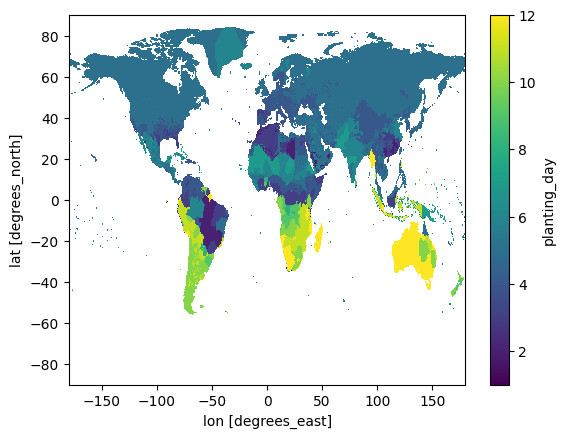

In [16]:
import xarray as xr
import pandas as pd
import numpy as np

# 读取数据（显式处理 timedelta 警告）
cal = xr.open_dataset(cal_path, decode_timedelta=True)
planting_day = cal['planting_day']  # xarray.DataArray (lat, lon)

# 定义转换函数
def day_to_month(day, year=2011):
    if pd.isna(day):
        return np.nan
    return (pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(day - 1, unit="D")).month

# 使用 xarray 计算
months = xr.apply_ufunc(
    day_to_month,
    planting_day,
    kwargs={'year': 2011},
    vectorize=True,
)

(months_2011).plot()  # 结果仍然是 xarray.DataArray

### data for median

#### SPEI

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import join
import numpy as np
import pandas as pd
import dask.array as da
import dask
from dask.diagnostics import ProgressBar
import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore") 
fp = r'E:'
# fp = r'D:\AAUDE\paper\paper8\data'

ssps = ['Historical', 'SSP126', 'SSP585']
# ssps = ['Historical']

def set_time_coords(data, start_date):
    months_since_start = data.time.values
    dates = [start_date + pd.DateOffset(months=int(month)) for month in months_since_start]
    data['time'] = dates
    return data

def median_mod(evp_files, var):
    ds_list = []
    for file in evp_files:
        try:
            # First open without chunks to inspect
            with xr.open_dataset(file) as ds:
                # Get optimal chunks (or use auto-chunking)
                chunks = {'time': min(12, len(ds.time))}  # Use smaller of 12 or time length
                
                # Reopen with chunks
                ds = xr.open_dataset(file, chunks=chunks)
                if 'time' in ds.coords:
                    ds['time'].encoding.clear()
                ds_list.append(ds[var])
        except Exception as e:
            print(f"Corrupted file: {file} | Error: {e}")
    
    if not ds_list:
        return None
    
    # Combine with auto-chunking
    combined = xr.concat(ds_list, dim='stack_dim', coords='minimal', compat='override')
    
    # Use dask's compute with progress bar
    with ProgressBar():
        median_ds = combined.median(dim='stack_dim', skipna=True).compute()
        
        # Ensure proper time encoding
        if 'time' in median_ds.coords:
            median_ds['time'].encoding.update({
                'units': 'days since 1900-01-01',
                'calendar': 'proleptic_gregorian'
            })
        return median_ds

scale=12
for ssp in ssps:
    evp_files = list(Path(join(r'D:\AAUDE\paper\paper8\data\spei')).glob(f'SPEI_scale{scale}_*_{ssp}.nc'))
    if not evp_files:
        print(f"No files found for {ssp}")
        continue
        
    evp = median_mod(evp_files, 'spei')
    
    if evp is not None:
        output_path = rf'D:\AAUDE\paper\paper8\data\result2\spei_scale{scale}_{ssp}_median_all.nc'
        encoding = {
            'time': {
                'units': 'days since 1901-01-01',
                'calendar': 'proleptic_gregorian'
            }
        }
        evp.to_netcdf(output_path, encoding=encoding)
        print(f"Saved {output_path}")
    else:
        print(f"No valid d+ata for {crop} {ssp}")

[########################################] | 100% Completed | 258.83 s
Saved D:\AAUDE\paper\paper8\data\result2\spei_scale12_Historical_median_all.nc
[########################################] | 100% Completed | 182.29 s
Saved D:\AAUDE\paper\paper8\data\result2\spei_scale12_SSP126_median_all.nc
[########################################] | 100% Completed | 186.22 s
Saved D:\AAUDE\paper\paper8\data\result2\spei_scale12_SSP585_median_all.nc


#### monthly ssi,sm

In [25]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import join
import numpy as np
import pandas as pd
import dask.array as da
import dask
from dask.diagnostics import ProgressBar
import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore") 
fp = r'F:'
# fp = r'D:\AAUDE\paper\paper8\data'
crops = ['mai', 'swh', 'wwh', 'soy']
ssps = ['Historical', 'SSP126', 'SSP585']
# ssps = ['Historical']

def set_time_coords(data, start_date):
    months_since_start = data.time.values
    dates = [start_date + pd.DateOffset(months=int(month)) for month in months_since_start]
    data['time'] = dates
    return data

def median_mod(evp_files, var):
    ds_list = []
    for file in evp_files:
        try:
            # First open without chunks to inspect
            with xr.open_dataset(file) as ds:
                # Get optimal chunks (or use auto-chunking)
                chunks = {'time': min(12, len(ds.time))}  # Use smaller of 12 or time length
                
                # Reopen with chunks
                ds = xr.open_dataset(file, chunks=chunks)
                if 'time' in ds.coords:
                    ds['time'].encoding.clear()
                ds_list.append(ds[var])
        except Exception as e:
            print(f"Corrupted file: {file} | Error: {e}")
    
    if not ds_list:
        return None
    
    # Combine with auto-chunking
    combined = xr.concat(ds_list, dim='stack_dim', coords='minimal', compat='override')
    
    # Use dask's compute with progress bar
    with ProgressBar():
        median_ds = combined.median(dim='stack_dim', skipna=True).compute()
        
        # Ensure proper time encoding
        if 'time' in median_ds.coords:
            median_ds['time'].encoding.update({
                'units': 'days since 1900-01-01',
                'calendar': 'proleptic_gregorian'
            })
        return median_ds

for crop in crops[2:]:
        # ssp=ssps[0]
    for ssp in ssps[:]:
        evp_files = list(Path(join(fp, 'ssi')).glob(f'SSI_{crop}_*_{ssp}_*_kde_2015co2.nc'))
        if not evp_files:
            print(f"No files found for {ssp}")
            continue
            
        evp = median_mod(evp_files, 'ssi')
        
        if evp is not None:
            output_path = rf'D:\AAUDE\paper\paper8\data\result2\ssi_scale3_{crop}_{ssp}_median_all_2015co2.nc'
            encoding = {
                'time': {
                    'units': 'days since 1901-01-01',
                    'calendar': 'proleptic_gregorian'
                }
            }
            evp.to_netcdf(output_path, encoding=encoding)
            print(f"Saved {output_path}")
        else:
            print(f"No valid d+ata for {crop} {ssp}")

[########################################] | 100% Completed | 12m 57s
Saved D:\AAUDE\paper\paper8\data\result2\ssi_scale3_wwh_Historical_median_all.nc
[########################################] | 100% Completed | 492.76 s
Saved D:\AAUDE\paper\paper8\data\result2\ssi_scale3_wwh_SSP126_median_all.nc
[########################################] | 100% Completed | 488.32 s
Saved D:\AAUDE\paper\paper8\data\result2\ssi_scale3_wwh_SSP585_median_all.nc
[########################################] | 100% Completed | 13m 32s
Saved D:\AAUDE\paper\paper8\data\result2\ssi_scale3_soy_Historical_median_all.nc
[########################################] | 100% Completed | 510.46 s
Saved D:\AAUDE\paper\paper8\data\result2\ssi_scale3_soy_SSP126_median_all.nc
[########################################] | 100% Completed | 507.47 s
Saved D:\AAUDE\paper\paper8\data\result2\ssi_scale3_soy_SSP585_median_all.nc


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import join
import numpy as np
import pandas as pd
import dask.array as da
import dask
from dask.diagnostics import ProgressBar
import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore") 
fp = r'D:\AAUDE\paper\paper8\data'
crops = ['mai', 'swh', 'wwh', 'soy']
ssps = ['Historical', 'SSP126', 'SSP585']
# ssps = ['Historical']

def set_time_coords(data, start_date):
    months_since_start = data.time.values
    dates = [start_date + pd.DateOffset(months=int(month)) for month in months_since_start]
    data['time'] = dates
    return data

def median_mod(evp_files, var):
    ds_list = []
    for file in evp_files:
        try:
            # First open without chunks to inspect
            with xr.open_dataset(file) as ds:
                # Get optimal chunks (or use auto-chunking)
                chunks = {'time': min(12, len(ds.time))}  # Use smaller of 12 or time length
                
                # Reopen with chunks
                ds = xr.open_dataset(file, chunks=chunks)
                if 'time' in ds.coords:
                    ds['time'].encoding.clear()
                ds_list.append(ds[var])
        except Exception as e:
            print(f"Corrupted file: {file} | Error: {e}")
    
    if not ds_list:
        return None
    
    # Combine with auto-chunking
    combined = xr.concat(ds_list, dim='stack_dim', coords='minimal', compat='override')
    
    # Use dask's compute with progress bar
    with ProgressBar():
        median_ds = combined.median(dim='stack_dim', skipna=True).compute()
        
        # Ensure proper time encoding
        if 'time' in median_ds.coords:
            median_ds['time'].encoding.update({
                'units': 'days since 1900-01-01',
                'calendar': 'proleptic_gregorian'
            })
        return median_ds

for crop in crops:
    for ssp in ssps[1:]:
        evp_files = list(Path(join(fp, 'spei')).glob(f'SPEI_scale2_{crop}*{ssp}*'))
        if not evp_files:
            print(f"No files found for {ssp}")
            continue
            
        evp = median_mod(evp_files, 'spei')
        
        if evp is not None:
            output_path = rf'D:\AAUDE\paper\paper8\data\resu\SPEI_scale2_{crop}_{ssp}_median.nc'
            encoding = {
                'time': {
                    'units': 'days since 1900-01-01',
                    'calendar': 'proleptic_gregorian'
                }
            }
            evp.to_netcdf(output_path, encoding=encoding)
            print(f"Saved {output_path}")
        else:
            print(f"No valid data for {crop} {ssp}")

[########################################] | 100% Completed | 167.61 s
Saved D:\AAUDE\paper\paper8\data\resu\SPEI_scale2_mai_SSP126_median.nc
[########################################] | 100% Completed | 167.48 s
Saved D:\AAUDE\paper\paper8\data\resu\SPEI_scale2_mai_SSP585_median.nc
[########################################] | 100% Completed | 215.92 s
Saved D:\AAUDE\paper\paper8\data\resu\SPEI_scale2_swh_SSP126_median.nc
[########################################] | 100% Completed | 202.63 s
Saved D:\AAUDE\paper\paper8\data\resu\SPEI_scale2_swh_SSP585_median.nc
[########################################] | 100% Completed | 199.14 s
Saved D:\AAUDE\paper\paper8\data\resu\SPEI_scale2_wwh_SSP126_median.nc
[########################################] | 100% Completed | 184.95 s
Saved D:\AAUDE\paper\paper8\data\resu\SPEI_scale2_wwh_SSP585_median.nc
[########################################] | 100% Completed | 219.61 s
Saved D:\AAUDE\paper\paper8\data\resu\SPEI_scale2_soy_SSP126_median.nc
[#####

In [33]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import join
import numpy as np
import pandas as pd
import dask.array as da
import dask
from dask.diagnostics import ProgressBar
import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore") 
fp = r'D:\AAUDE\paper\paper8\data'
crops = ['mai', 'swh', 'wwh', 'soy']
ssps = ['historical', 'ssp126', 'ssp585']

def set_time_coords(data, start_date):
    months_since_start = data.time.values
    dates = [start_date + pd.DateOffset(months=int(month)) for month in months_since_start]
    data['time'] = dates
    return data

def median_mod(evp_files, var):
    ds_list = []
    for file in evp_files:
        try:
            # First open without chunks to inspect
            with xr.open_dataset(file) as ds:
                # Get optimal chunks (or use auto-chunking)
                chunks = {'time': min(12, len(ds.time))}  # Use smaller of 12 or time length
                
                # Reopen with chunks
                ds = xr.open_dataset(file, chunks=chunks)
                if 'time' in ds.coords:
                    ds['time'].encoding.clear()
                ds_list.append(ds[var])
        except Exception as e:
            print(f"Corrupted file: {file} | Error: {e}")
    
    if not ds_list:
        return None
    
    # Combine with auto-chunking
    combined = xr.concat(ds_list, dim='stack_dim', coords='minimal', compat='override')
    
    # Use dask's compute with progress bar
    with ProgressBar():
        median_ds = combined.median(dim='stack_dim', skipna=True).compute()
        
        # Ensure proper time encoding
        if 'time' in median_ds.coords:
            median_ds['time'].encoding.update({
                'units': 'days since 1900-01-01',
                'calendar': 'proleptic_gregorian'
            })
        return median_ds

for crop in crops:
    for ssp in ssps:
        evp_files = list(Path(join(fp, 'spei')).glob(f'SPEI_scale{scale}_{crop}*_{ssp}.nc*'))
        if not evp_files:
            print(f"No files found for {crop} {ssp}")
            continue
            # (rf'D:\AAUDE\paper\paper8\data\spei\SPEI_scale{scale}_{crop}_{gcm}_{ssp}.nc')
        evp = median_mod(evp_files, 'spei')
        
        if evp is not None:
            output_path = rf'D:\AAUDE\paper\paper8\data\resu\spei_{crop}_{ssp}_scale2_median.nc'
            encoding = {
                'time': {
                    'units': 'days since 1900-01-01',
                    'calendar': 'proleptic_gregorian'
                }
            }
            evp.to_netcdf(output_path, encoding=encoding)
            print(f"Saved {output_path}")
        else:
            print(f"No valid data for {crop} {ssp}")

[########################################] | 100% Completed | 179.66 s
Saved D:\AAUDE\paper\paper8\data\resu\spei_mai_historical_scale2_median.nc
No files found for mai ssp126
No files found for mai ssp585
[########################################] | 100% Completed | 187.04 s
Saved D:\AAUDE\paper\paper8\data\resu\spei_swh_historical_scale2_median.nc
No files found for swh ssp126
No files found for swh ssp585
[#########################               ] | 64% Completed | 113.56 s



KeyboardInterrupt



In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import join
import numpy as np
import pandas as pd
import dask.array as da
fp=r'E:\isimip3b_agricultal'
crops = [ 'mai','swh','wwh', 'soy']

def set_time_coords(data, start_date):
    months_since_start = data.time.values
    dates = [start_date + pd.DateOffset(months=int(month)) for month in months_since_start]
    data['time'] = dates
    return data

ssps=['historical','ssp126','ssp585']
import dask
from dask.diagnostics import ProgressBar

def median_mod(evp_files, var):
    ds_list = []
    for file in evp_files:
        try:
            # Open with chunks for lazy loading
            ds = xr.open_dataset(file, chunks={'time': 12})  # 12 months per year
            # Ensure time variable is properly encoded
            if 'time' in ds.coords:
                ds['time'].encoding.clear()  # Clear any problematic encodings
            ds_list.append(ds[var])
        except Exception as e:
            print(f"Corrupted file: {file} | Error: {e}")
    
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        combined = xr.concat(ds_list, dim='stack_dim')
        median_ds = combined.median(dim='stack_dim', skipna=True)
        # print(ds_list)
        with ProgressBar():
            result = median_ds.compute()
            
            # Ensure time variable is properly encoded before saving
            if 'time' in result.coords:
                result['time'].encoding.update({
                    'units': 'days since 1900-01-01',
                    'calendar': 'proleptic_gregorian'
                })
            return result

for crop in crops[3:]:
    for ssp in ssps:
        evp_files = list(Path(join(fp, 'soilmoist')).glob(f'*{ssp}_2015soc_default_soilmoist-{crop}-firr_global_monthly*.nc'))
        evp = median_mod(evp_files, f'soilmoist-{crop}-firr')
        
        # Save with explicit encoding for time variable
        encoding = {
            'time': {
                'units': 'days since 1900-01-01',
                'calendar': 'proleptic_gregorian'
            }
        }
        evp.to_netcdf(rf'D:\AAUDE\paper\paper8\data\result2\soilmoist_{crop}_{ssp}_median_firr.nc', 
                     encoding=encoding)

#### annual yield,evapcum

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import join
import numpy as np
import pandas as pd
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=4)
client = Client(cluster)

# 中位数函数使用 dask 加速
def median_mod_dask(evp_files, var, time):
    ds_list = []
    for i, file in enumerate(evp_files):
        da = xr.open_dataset(file, decode_times=False, chunks={})[var]
        # 添加时间轴（按顺序分配）
        da['time'] = time  # 确保有 time 维
        ds_list.append(da)

    combined = xr.concat(ds_list, dim='stack_dim')  # 按时间拼接
    median_ds = combined.median(dim='stack_dim', skipna=True)  # 对时间维求中位数
    return median_ds


fp = r'E:\isimip3b_agricultal'
crops = ['mai', 'swh', 'wwh', 'soy']
ssps = ['historical', 'ssp126', 'ssp585']
for exp in exps:
    for crop in crops:
        for ssp in ssps:
            print(f"Processing {crop} - {ssp}")
            
            if ssp == 'historical':
                time = pd.date_range("1850-01-01", "2014-12-01", freq='YS')
            else:
                time = pd.date_range("2015-01-01", "2100-12-01", freq='YS')
    
            # 文件路径列表
            yield_files = list(Path(join(fp, 'yield')).glob(f'*_{ssp}_2015soc_{exp}_yield-{crop}-noirr_global_annual-gs*.nc'))
            pirnreqcum_files = list(Path(join(fp, 'pirnreqcum')).glob(f'*_{ssp}_2015soc_{exp}_pirnreqcum-{crop}-firr_global_annual-gs*.nc'))
            evp_files = list(Path(join(fp, 'evapcum')).glob(f'*{ssp}_2015soc_{exp}_evapcum-{crop}-noirr_global_annual-gs*.nc'))
    
            # 并行惰性计算
            yied = median_mod_dask(yield_files, f'yield-{crop}-noirr',time)
            evp = median_mod_dask(evp_files, f'evapcum-{crop}-noirr',time)
            pirnreqcum = median_mod_dask(pirnreqcum_files, f'pirnreqcum-{crop}-firr',time)
    
            # 添加时间坐标（触发计算）
            yied['time'] = time
            evp['time'] = time
            pirnreqcum['time'] = time
            pirnreqcum.compute().to_netcdf(rf'D:\AAUDE\paper\paper8\data\result2\pirnreqcum_{crop}_{ssp}_median_{exp}.nc')


Processing mai - historical
Processing mai - ssp126
Processing mai - ssp585
Processing swh - historical
Processing swh - ssp126
Processing swh - ssp585
Processing wwh - historical
Processing wwh - ssp126
Processing wwh - ssp585
Processing soy - historical
Processing soy - ssp126
Processing soy - ssp585


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import join
import numpy as np
import pandas as pd
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=4)
client = Client(cluster)

# 中位数函数使用 dask 加速
def median_mod_dask(evp_files, var, time):
    ds_list = []
    for i, file in enumerate(evp_files):
        da = xr.open_dataset(file, decode_times=False, chunks={})[var]
        # 添加时间轴（按顺序分配）
        da['time'] = time  # 确保有 time 维
        ds_list.append(da)

    combined = xr.concat(ds_list, dim='stack_dim')  # 按时间拼接
    median_ds = combined.median(dim='stack_dim', skipna=True)  # 对时间维求中位数
    return median_ds

exps = ['default', '2015co2']
fp = r'E:\isimip3b_agricultal'
crops = ['mai', 'swh', 'wwh', 'soy']
ssps = ['historical', 'ssp126', 'ssp585']
for exp in exps:
    for crop in crops:
        for ssp in ssps:
            print(f"Processing {crop} - {ssp}-{exp}")
            
            if ssp == 'historical':
                time = pd.date_range("1850-01-01", "2014-12-01", freq='YS')
            else:
                time = pd.date_range("2015-01-01", "2100-12-01", freq='YS')
        
            pirnreqcum_files = list(Path(join(fp, 'pirnreqcum')).glob(f'*_{ssp}_2015soc_2015co2_pirnreqcum-{crop}-firr_global_annual-gs*.nc'))

            pirnreqcum = median_mod_dask(pirnreqcum_files, f'pirnreqcum-{crop}-firr',time)
    
            pirnreqcum['time'] = time

            pirnreqcum.compute().to_netcdf(rf'D:\AAUDE\paper\paper8\data\result2\pirnreqcum_{crop}_{ssp}_median_{exp}.nc')


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63686 instead
  warnings.warn(


Processing mai - historical-default
Processing mai - ssp126-default
Processing mai - ssp585-default
Processing swh - historical-default
Processing swh - ssp126-default
Processing swh - ssp585-default
Processing wwh - historical-default
Processing wwh - ssp126-default
Processing wwh - ssp585-default
Processing soy - historical-default
Processing soy - ssp126-default
Processing soy - ssp585-default
Processing mai - historical-2015co2
Processing mai - ssp126-2015co2
Processing mai - ssp585-2015co2
Processing swh - historical-2015co2
Processing swh - ssp126-2015co2
Processing swh - ssp585-2015co2
Processing wwh - historical-2015co2
Processing wwh - ssp126-2015co2
Processing wwh - ssp585-2015co2
Processing soy - historical-2015co2
Processing soy - ssp126-2015co2
Processing soy - ssp585-2015co2


In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import join
import numpy as np
import pandas as pd
import dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=4)
client = Client(cluster)

# 中位数函数使用 dask 加速
def median_mod_dask(evp_files, var, time):
    ds_list = []
    for i, file in enumerate(evp_files):
        da = xr.open_dataset(file, decode_times=False, chunks={})[var]
        # 添加时间轴（按顺序分配）
        da['time'] = time  # 确保有 time 维
        ds_list.append(da)

    combined = xr.concat(ds_list, dim='stack_dim')  # 按时间拼接
    median_ds = combined.median(dim='stack_dim', skipna=True)  # 对时间维求中位数
    return median_ds


fp = r'E:\isimip3b_agricultal'
crops = ['mai', 'swh', 'wwh', 'soy']
ssps = ['historical', 'ssp126', 'ssp585']

for crop in crops:
    for ssp in ssps:
        print(f"Processing {crop} - {ssp}")
        
        if ssp == 'historical':
            time = pd.date_range("1850-01-01", "2014-12-01", freq='YS')
        else:
            time = pd.date_range("2015-01-01", "2100-12-01", freq='YS')

        # 文件路径列表
        yield_files = list(Path(join(fp, 'yield')).glob(f'*_{ssp}_2015soc_2015co2_yield-{crop}-noirr_global_annual-gs*.nc'))
        pirnreqcum_files = list(Path(join(fp, 'pirnreqcum')).glob(f'*_{ssp}_2015soc_2015co2_pirnreqcum-{crop}-firr_global_annual-gs*.nc'))
        evp_files = list(Path(join(fp, 'evapcum')).glob(f'*{ssp}_2015soc_2015co2_evapcum-{crop}-noirr_global_annual-gs*.nc'))

        # 并行惰性计算
        yied = median_mod_dask(yield_files, f'yield-{crop}-noirr',time)
        evp = median_mod_dask(evp_files, f'evapcum-{crop}-noirr',time)
        pirnreqcum = median_mod_dask(pirnreqcum_files, f'pirnreqcum-{crop}-firr',time)

        # 添加时间坐标（触发计算）
        yied['time'] = time
        evp['time'] = time
        pirnreqcum['time'] = time

        # 保存，使用 compute 显式触发
        yied.compute().to_netcdf(rf'D:\AAUDE\paper\paper8\data\result2\yield_{crop}_{ssp}_median_2015co2.nc')
        evp.compute().to_netcdf(rf'D:\AAUDE\paper\paper8\data\result2\evapcum_{crop}_{ssp}_median_2015co2.nc')
        pirnreqcum.compute().to_netcdf(rf'D:\AAUDE\paper\paper8\data\result2\pirnreqcum_{crop}_{ssp}_median_2015co2.nc')


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62529 instead
  warnings.warn(
C:\Program Files\Python311\Lib\contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (2.19s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Processing mai - historical
Processing mai - ssp126
Processing mai - ssp585
Processing swh - historical
Processing swh - ssp126
Processing swh - ssp585
Processing wwh - historical
Processing wwh - ssp126
Processing wwh - ssp585
Processing soy - historical
Processing soy - ssp126
Processing soy - ssp585


In [3]:
def set_time_coords(data, start_year=1850):
    """正确设置时间坐标（保持86年不变）"""
    # 生成完整的时间序列（2015-01-01到2100-01-01，共86个点）
    dates = pd.date_range(
        start=f'{start_year}-01-01',
        periods=len(data.time),  # 直接使用原始时间维度长度
        freq='YS'  # 年初作为标记点
    )
    
    days_since_ref = (dates - pd.Timestamp(f'{start_year}-01-01')).days
    data['time'] = days_since_ref
    
    # 设置CF合规的时间编码
    data.time.encoding.update({
        'units': f'days since {start_year}-01-01',  # 改为days
        'calendar': 'standard'
    })
    return data

def mean_mod(evp_files,var):
    sum_ds = None
    valid_files_count = 0
    
    for file in evp_files:
        ds = xr.open_dataset(file,decode_times=False)[var]
        ds=set_time_coords(ds)
        if sum_ds is None:
            sum_ds = ds.copy()
        else:
            sum_ds = sum_ds + ds
        # print(len(sum_ds.time),file)
        valid_files_count += 1
    return sum_ds/valid_files_count
def median_mod(evp_files, var):
    ds_list = []
    for file in evp_files:
        ds = xr.open_dataset(file, decode_times=False)[var]
        ds = set_time_coords(ds)
        ds_list.append(ds)
    
    # 堆叠并计算中位数
    combined = xr.concat(ds_list, dim='stack_dim')  # 新维度
    median_ds = combined.median(dim='stack_dim', skipna=True)
    return median_ds

import xarray as xr
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import join
import numpy as np
import pandas as pd
### ssp126
fp=r'E:\isimip3b_agricultal'
crops = [ 'mai','swh','wwh', 'soy']

ssps=['ssp126','ssp585']
for crop in crops:
    # for ssp in ssps:
        ssp='historical'
        yield_files=list(Path(join(fp,'yield')).glob(f'*gfdl-esm4_w5e5_{ssp}_2015soc_default_yield-{crop}-noirr_global_annual-gs*.nc'))
        # evp_files=list(Path(join(fp,'evapcum')).glob(f'*{ssp}_2015soc_default_evapcum-{crop}-noirr_global_annual-gs*.nc'))
        yied=median_mod(yield_files,f'yield-{crop}-noirr')
        # evp=median_mod(evp_files,f'evapcum-{crop}-noirr')
        # if 'time' in yied.coords:
        yied['time'].attrs.pop('units', None)
        yied['time'].attrs.pop('calendar', None)
        # evp['time'].attrs.pop('units', None)
        # evp['time'].attrs.pop('calendar', None)
        yied.to_netcdf(rf'D:\AAUDE\paper\paper8\data\resu\yield_{crop}_{ssp}_gfdl-esm4_w5e5_median.nc')
        # evp.to_netcdf(rf'D:\AAUDE\paper\paper8\data\resu\evapcum_{crop}_{ssp}_median.nc')

### Expect yield

In [2]:
import xarray as xr
from os.path import join
import numpy as np

# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'wwh', 'swh']
exps = ['default', '2015co2']

for exp in exps:
    for ssp in ssps:
        # if exp == '2015co2' and ssp == 'historical':
        #     continue
        for crop in crops:
            fp = r'D:\AAUDE\paper\paper8\data\result2'
            area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
            area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
            yied = xr.open_dataset(join(fp, f'yield_{crop}_{ssp}_median_{exp}.nc'))[f'yield-{crop}-noirr'][:-1]
            yied=yied.where(area>0)
            # Apply 20-year moving average
            # Using center=False to get trailing moving average
            yied_smooth = yied.rolling(time=20, center=False, min_periods=1).mean()
            
            # Create new dataset to save
            ds_smooth = xr.Dataset()
            ds_smooth[f'yield-{crop}-noirr'] = yied_smooth
            
            # Save the smoothed data
            output_path = join(r'D:\AAUDE\paper\paper8\data\expect_yield', f'exptct_yield_{crop}_{ssp}_{exp}_smooth22.nc')
            ds_smooth.to_netcdf(output_path)
            print(f'Saved: {output_path}')

Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_mai_historical_default_smooth22.nc
Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_soy_historical_default_smooth22.nc
Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_wwh_historical_default_smooth22.nc
Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_swh_historical_default_smooth22.nc
Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_mai_ssp126_default_smooth22.nc
Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_soy_ssp126_default_smooth22.nc
Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_wwh_ssp126_default_smooth22.nc
Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_swh_ssp126_default_smooth22.nc
Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_mai_ssp585_default_smooth22.nc
Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_soy_ssp585_default_smooth22.nc
Saved: D:\AAUDE\paper\paper8\data\expect_yield\exptct_yield_wwh_ssp585_def

In [2]:
import numpy as np
import xarray as xr
from scipy.stats import linregress
from tqdm.notebook import tqdm
from os.path import join
def calculate_expected_yield(yield_data, significance_level=0.05, output_path=None):

    years = yield_data.time.dt.year.values
    n_years = len(years)

    # 初始化输出数组
    slopes = np.full(yield_data.shape[1:], np.nan)
    intercepts = np.full(yield_data.shape[1:], np.nan)
    p_values = np.full(yield_data.shape[1:], np.nan)
    significant = np.full(yield_data.shape[1:], False, dtype=bool)

    print("计算每个格点的预期产量趋势并进行显著性检验...")
    for i in tqdm(range(yield_data.shape[1]), desc="纬度维度"):
        for j in range(yield_data.shape[2]):
            y = yield_data[:, i, j].values
            valid_mask = ~np.isnan(y)
            valid_y = y[valid_mask]
            valid_years = years[valid_mask]

            if len(valid_y) >= 3:
                try:
                    slope, intercept, r_value, p_value, std_err = linregress(valid_years, valid_y)
                    slopes[i, j] = slope
                    intercepts[i, j] = intercept
                    p_values[i, j] = p_value
                    significant[i, j] = p_value < significance_level
                except Exception:
                    pass  # 错误处理：跳过不合法点

    # 计算预期产量
    # 直接使用年份，而不是 year_diffs
    expected_yield = np.empty((n_years, *slopes.shape), dtype=np.float32)
    
    for t in range(n_years):
        expected_yield[t, :, :] = slopes * years[t] + intercepts


    # 构建 xarray.DataArray 对象
    expected_yield_da = xr.DataArray(
        expected_yield,
        dims=['time', 'lat', 'lon'],
        coords={
            'time': yield_data.time,
            'lat': yield_data.lat,
            'lon': yield_data.lon
        },
        name='expected_yield'
    )

    significant_da = xr.DataArray(
        significant,
        dims=['lat', 'lon'],
        coords={'lat': yield_data.lat, 'lon': yield_data.lon},
        name='significant_trend'
    )

    p_values_da = xr.DataArray(
        p_values,
        dims=['lat', 'lon'],
        coords={'lat': yield_data.lat, 'lon': yield_data.lon},
        name='p_value'
    )

    # 若指定路径，则保存为 NetCDF 文件
    if output_path is not None:
        print(f"保存 NetCDF 文件到: {output_path}")
        ds_out = xr.Dataset({
            'expected_yield': expected_yield_da,
            'significant_trend': significant_da,
            'p_value': p_values_da
        })
        ds_out.to_netcdf(output_path)
        print("保存完成。")

    return expected_yield_da, significant_da, p_values_da
for exp in ['default','2015co2']:
    for crop in ['mai','soy','swh','wwh']:
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        for ssp in ['historical','ssp126','ssp585']:
            yield_data = xr.open_dataset( rf'D:\AAUDE\paper\paper8\data\result2\yield_{crop}_{ssp}_median_{exp}.nc')[f'yield-{crop}-noirr']
            output_nc_file = rf"D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_{crop}_{ssp}_{exp}_v2.nc" 
            
            expected_yield, significant_mask, pvals = calculate_expected_yield(
                yield_data.where((area>0)),
                significance_level=0.05,
                output_path=output_nc_file
            )


ERROR! Session/line number was not unique in database. History logging moved to new session 990
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_mai_historical_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_mai_ssp126_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_mai_ssp585_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_soy_historical_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_soy_ssp126_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_soy_ssp585_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_swh_historical_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_swh_ssp126_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_swh_ssp585_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_wwh_historical_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_wwh_ssp126_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_wwh_ssp585_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_mai_historical_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_mai_ssp126_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_mai_ssp585_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_soy_historical_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_soy_ssp126_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_soy_ssp585_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_swh_historical_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_swh_ssp126_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_swh_ssp585_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_wwh_historical_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_wwh_ssp126_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_yield_wwh_ssp585_2015co2_v2.nc
保存完成。


In [4]:
import xarray as xr
from os.path import join
import numpy as np
# 定义所有需要遍历的维度
ssps = ['historical', 'ssp126', 'ssp585']
crops = ['mai', 'soy', 'whe']
drought_vars = ['ssi', 'spei']
exps=['default','2015co2']
# var='ssi'
result_dict1 = {
    exp:{ssp: {
            crop: {} for crop in crops
    } for ssp in ssps} for exp in exps
}
def change(data,yied,ssp):
    data = data[1:].rename({'year': 'time'})
    # if ssp == 'historical':
    data['time']=yied.time.values
    return data.where(np.isfinite(data))

for exp in exps:
    for ssp in ssps:
        if exp =='2015co2' and ssp=='historical':
            continue
        for crop in crops:
            # 特殊处理小麦（合并冬小麦和春小麦）
            if crop == 'whe':
                try:
                    fp = r'D:\AAUDE\paper\paper8\data\result2'
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_wwh_R.nc')
                    area_wwh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_swh_R.nc')
                    area_swh = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                    ssi_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    ssi_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                    spei_data_swh = xr.open_dataset(join(fp, f'swh_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    spei_data_wwh = xr.open_dataset(join(fp, f'wwh_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                    yied_wwh= xr.open_dataset(join(fp, f'yield_wwh_{ssp}_median_{exp}.nc'))[f'yield-wwh-noirr'][-len(ssi_data_wwh):-1]
                    yied_swh= xr.open_dataset(join(fp, f'yield_swh_{ssp}_median_{exp}.nc'))[f'yield-swh-noirr'][-len(ssi_data_wwh):-1]
                    ssi_data_wwh=change(ssi_data_wwh,yied_wwh,ssp)
                    ssi_data_swh=change(ssi_data_swh,yied_wwh,ssp)
                    spei_data_swh=change(spei_data_swh,yied_wwh,ssp)
                    spei_data_wwh=change(spei_data_wwh,yied_wwh,ssp)
                    swd=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_daily_wwh_{ssp}_{exp}.nc')['swd'].where(area_wwh>0).fillna(0)+\
                    xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_daily_swh_{ssp}_{exp}.nc')['swd'].where(area_swh>0).fillna(0)
                    yied=yied_wwh.where(area_wwh>0).fillna(0)+yied_swh.where(area_swh>0).fillna(0)
                    ssi=ssi_data_wwh.where(area_wwh>0).fillna(0)+ssi_data_swh.where(area_swh>0).fillna(0)
                    spei=spei_data_wwh.where(area_wwh>0).fillna(0)+spei_data_swh.where(area_swh>0).fillna(0)
                    result_dict1[exp][ssp][crop]['yield'] =yied.where(yied!=0)
                    result_dict1[exp][ssp][crop]['spei'] = spei.where(spei!=0)
                    result_dict1[exp][ssp][crop]['ssi'] = ssi.where(ssi!=0)
                    result_dict1[exp][ssp][crop]['swd'] = swd.where(swd!=0)
                except:
                    print(f"Warning: 缺少小麦数据文件 for {var}-{ssp}")
                    continue
            else:
                # try:
                fp = r'D:\AAUDE\paper\paper8\data\result2'
                area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
                area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
                ssi_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_ssi_growing_season_mean_parallel_{exp}.nc'))['ssi_gs_mean']
                spei_data = xr.open_dataset(join(fp, f'{crop}_{ssp}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean']
                yied= xr.open_dataset(join(fp, f'yield_{crop}_{ssp}_median_{exp}.nc'))[f'yield-{crop}-noirr'][-len(ssi_data):-1]
                swd=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\result2\swd_daily_{crop}_{ssp}_{exp}.nc')['swd'].where(area>0)
                ssi_data=change(ssi_data,yied,ssp)
                spei_data=change(spei_data,yied,ssp)
                result_dict1[exp][ssp][crop]['yield'] =yied.where(area>0)
                result_dict1[exp][ssp][crop]['spei'] = spei_data.where(area>0)
                result_dict1[exp][ssp][crop]['ssi'] = ssi_data.where(area>0)
                result_dict1[exp][ssp][crop]['swd'] = swd.where(swd!=0)

In [6]:
import numpy as np
import xarray as xr
from scipy.stats import linregress
from tqdm.notebook import tqdm
from os.path import join
def calculate_expected_yield(yield_data, significance_level=0.05, output_path=None):

    years = yield_data.time.dt.year.values
    n_years = len(years)

    # 初始化输出数组
    slopes = np.full(yield_data.shape[1:], np.nan)
    intercepts = np.full(yield_data.shape[1:], np.nan)
    p_values = np.full(yield_data.shape[1:], np.nan)
    significant = np.full(yield_data.shape[1:], False, dtype=bool)

    print("计算每个格点的预期产量趋势并进行显著性检验...")
    for i in tqdm(range(yield_data.shape[1]), desc="纬度维度"):
        for j in range(yield_data.shape[2]):
            y = yield_data[:, i, j].values
            valid_mask = ~np.isnan(y)
            valid_y = y[valid_mask]
            valid_years = years[valid_mask]

            if len(valid_y) >= 3:
                try:
                    slope, intercept, r_value, p_value, std_err = linregress(valid_years, valid_y)
                    slopes[i, j] = slope
                    intercepts[i, j] = intercept
                    p_values[i, j] = p_value
                    significant[i, j] = p_value < significance_level
                except Exception:
                    pass  # 错误处理：跳过不合法点

    # 计算预期产量
    # 直接使用年份，而不是 year_diffs
    expected_yield = np.empty((n_years, *slopes.shape), dtype=np.float32)
    
    for t in range(n_years):
        expected_yield[t, :, :] = slopes * years[t] + intercepts


    # 构建 xarray.DataArray 对象
    expected_yield_da = xr.DataArray(
        expected_yield,
        dims=['time', 'lat', 'lon'],
        coords={
            'time': yield_data.time,
            'lat': yield_data.lat,
            'lon': yield_data.lon
        },
        name='expected_yield'
    )

    significant_da = xr.DataArray(
        significant,
        dims=['lat', 'lon'],
        coords={'lat': yield_data.lat, 'lon': yield_data.lon},
        name='significant_trend'
    )

    p_values_da = xr.DataArray(
        p_values,
        dims=['lat', 'lon'],
        coords={'lat': yield_data.lat, 'lon': yield_data.lon},
        name='p_value'
    )

    # 若指定路径，则保存为 NetCDF 文件
    if output_path is not None:
        print(f"保存 NetCDF 文件到: {output_path}")
        ds_out = xr.Dataset({
            'expected_yield': expected_yield_da,
            'significant_trend': significant_da,
            'p_value': p_values_da
        })
        ds_out.to_netcdf(output_path)
        print("保存完成。")

    return expected_yield_da, significant_da, p_values_da
for exp in ['default','2015co2']:
    for crop in ['mai','soy','whe']:
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        for ssp in ['historical','ssp126','ssp585']:
            if exp =='2015co2' and ssp=='historical':
                continue
            yield_data = result_dict1[exp][ssp][crop]['swd']
            output_nc_file = rf"D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_{crop}_{ssp}_{exp}_v2.nc" 
            
            expected_yield, significant_mask, pvals = calculate_expected_yield(
                yield_data.where((area>0)),
                significance_level=0.05,
                output_path=output_nc_file
            )

计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_mai_historical_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_mai_ssp126_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_mai_ssp585_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_soy_historical_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_soy_ssp126_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_soy_ssp585_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_whe_historical_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_whe_ssp126_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_whe_ssp585_default_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_mai_ssp126_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_mai_ssp585_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_soy_ssp126_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_soy_ssp585_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_whe_ssp126_2015co2_v2.nc
保存完成。
计算每个格点的预期产量趋势并进行显著性检验...


纬度维度:   0%|          | 0/360 [00:00<?, ?it/s]

保存 NetCDF 文件到: D:\AAUDE\paper\paper8\data\expect_yield\expected_swd_whe_ssp585_2015co2_v2.nc
保存完成。


### Trend

In [4]:
from dask.distributed import Client
import xarray as xr
import numpy as np
from scipy.stats import kendalltau
from os.path import join
import dask.array as da
import os

# 启动Dask集群（根据内存调整线程数）
client = Client(n_workers=20, threads_per_worker=2)

# ----------------------------
# 1. 定义核心函数（优化版）
# ----------------------------
def sen_slope(y):
    """向量化计算 Sen's Slope"""
    y_clean = y[~np.isnan(y)]
    n = len(y_clean)
    if n < 2:
        return np.nan
    j, i = np.triu_indices(n, k=1)
    slopes = (y_clean[j] - y_clean[i]) / (j - i)
    return np.median(slopes)

def mk_test(y):
    """Mann-Kendall检验（优化版）"""
    y_clean = y[~np.isnan(y)]
    if len(y_clean) < 2:
        return np.nan
    return kendalltau(np.arange(len(y_clean)), y_clean).pvalue

def calculate_trend_chunk(y):
    return sen_slope(y), mk_test(y)

def calculate_and_save_trend(data, crop, variable, scenario, output_dir):
    """确保输出坐标与输入完全一致"""
    # 检查输入数据是否包含正确的坐标
    if not all(dim in data.dims for dim in ['time', 'lat', 'lon']):
        data = data.transpose('time', 'lat', 'lon')
    
    # 分块策略（根据数据大小调整）
    data = data.chunk({'lat': 50, 'lon': 50, 'time': -1})
    
    # 并行计算趋势
    results = xr.apply_ufunc(
        calculate_trend_chunk,
        data,
        input_core_dims=[['time']],
        output_core_dims=[[], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float],
        keep_attrs=True
    )
    
    # 获取原始坐标（确保顺序一致）
    lat_coords = data.lat
    lon_coords = data.lon
    
    # 显式重建DataArray，强制对齐坐标
    slope_map = xr.DataArray(
        results[0].compute(),
        dims=['lat', 'lon'],
        coords={'lat': lat_coords, 'lon': lon_coords},
        attrs={'_FillValue': np.nan}
    )
    
    p_map = xr.DataArray(
        results[1].compute(),
        dims=['lat', 'lon'],
        coords={'lat': lat_coords, 'lon': lon_coords},
        attrs={'_FillValue': np.nan}
    )
    
    # 创建Dataset并确保维度顺序
    ds_out = xr.Dataset({
        'sen_slope': slope_map.transpose('lat', 'lon'),
        'p_value': p_map.transpose('lat', 'lon')
    })
    
    # 保存结果
    output_path = join(output_dir, f'trend_{variable}_{crop}_{scenario}.nc')
    ds_out.to_netcdf(output_path)
    print(f"结果已保存：{output_path}")
# ----------------------------
# 2. 数据加载与预处理（优化版）
# ----------------------------
crops = ['mai','swh', 'wwh', 'soy']
crop = crops[0]  # 示例使用soy
fp = r'D:\AAUDE\paper\paper8\data\resu'

# 2.1 加载并预处理面积掩码
area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

# 2.2 定义数据加载函数（统一处理分块和掩码）
def load_and_mask(var_name, scenario, chunks={'time': 10, 'lat': 100, 'lon': 100}):
    """优化：读取时直接分块+并行化掩码"""
    ds = xr.open_dataset(join(fp, f'{var_name}_{crop}_{scenario}_median.nc'), chunks=chunks)
    ds=ds.where(ds!=0)
    var = ds[f'{var_name}-{crop}-noirr' if var_name != 'ssi' else '__xarray_dataarray_variable__']
    return var.transpose('time', 'lat', 'lon').where(area > 0).persist()  # 触发并行计算
def load_and_mask1(var_name, scenario, chunks={'time': 10, 'lat': 100, 'lon': 100}):
    """优化：读取时直接分块+并行化掩码"""
    ds = xr.open_dataset(join(fp, f'{var_name}_{crop}_{scenario}_scale2_median.nc'), chunks=chunks)
    ds=ds.where(ds!=0)
    var = ds['ssi']
    return var.transpose('time', 'lat', 'lon').where(area > 0).persist()  # 触发并行计算
# 2.3 并行加载所有数据（使用Dask的persist加速）
print("Loading data...")
datasets = {
    'yield': {
        'ssp585': load_and_mask('yield', 'ssp585'),
        'ssp126': load_and_mask('yield', 'ssp126'),
        'historical': load_and_mask('yield', 'historical')
    },
    'evp': {
        'ssp585': load_and_mask('evapcum', 'ssp585'),
        'ssp126': load_and_mask('evapcum', 'ssp126'),
        'historical': load_and_mask('evapcum', 'historical')
    },
    'ssi': {
        'ssp585': load_and_mask1('ssi', 'ssp585'),
        'ssp126': load_and_mask1('ssi', 'ssp126'),
        'historical': load_and_mask1('ssi', 'historical')
    }
}

# ----------------------------
# 3. 计算并保存趋势
# ----------------------------
output_dir = r'D:\AAUDE\paper\paper8\data\resu'
os.makedirs(output_dir, exist_ok=True)

for var_name, scenarios in datasets.items():
    for scenario, data in scenarios.items():
        print(f"Processing {var_name} {scenario}...")
        calculate_and_save_trend(data, crop, var_name, scenario, output_dir)

# 关闭Dask集群
client.close()
print("All done!")

Loading data...
Processing yield ssp585...
结果已保存：D:\AAUDE\paper\paper8\data\resu\trend_yield_mai_ssp585.nc
Processing yield ssp126...
结果已保存：D:\AAUDE\paper\paper8\data\resu\trend_yield_mai_ssp126.nc
Processing yield historical...
结果已保存：D:\AAUDE\paper\paper8\data\resu\trend_yield_mai_historical.nc
Processing evp ssp585...
结果已保存：D:\AAUDE\paper\paper8\data\resu\trend_evp_mai_ssp585.nc
Processing evp ssp126...
结果已保存：D:\AAUDE\paper\paper8\data\resu\trend_evp_mai_ssp126.nc
Processing evp historical...
结果已保存：D:\AAUDE\paper\paper8\data\resu\trend_evp_mai_historical.nc
Processing ssi ssp585...
结果已保存：D:\AAUDE\paper\paper8\data\resu\trend_ssi_mai_ssp585.nc
Processing ssi ssp126...
结果已保存：D:\AAUDE\paper\paper8\data\resu\trend_ssi_mai_ssp126.nc
Processing ssi historical...
结果已保存：D:\AAUDE\paper\paper8\data\resu\trend_ssi_mai_historical.nc
All done!


In [3]:
from dask.distributed import Client
import xarray as xr
import numpy as np
from scipy.stats import kendalltau
from os.path import join
import dask.array as da
import os

# 启动Dask集群（根据内存调整线程数）
client = Client(n_workers=20, threads_per_worker=2)

# ----------------------------
# 1. 定义核心函数（优化版）
# ----------------------------
def sen_slope(y):
    """向量化计算 Sen's Slope"""
    y_clean = y[~np.isnan(y)]
    n = len(y_clean)
    if n < 2:
        return np.nan
    j, i = np.triu_indices(n, k=1)
    slopes = (y_clean[j] - y_clean[i]) / (j - i)
    return np.median(slopes)

def mk_test(y):
    """Mann-Kendall检验（优化版）"""
    y_clean = y[~np.isnan(y)]
    if len(y_clean) < 2:
        return np.nan
    return kendalltau(np.arange(len(y_clean)), y_clean).pvalue

def calculate_trend_chunk(y):
    return sen_slope(y), mk_test(y)

def calculate_and_save_trend(data, crop, variable, scenario, output_dir):
    """确保输出坐标与输入完全一致"""
    # 检查输入数据是否包含正确的坐标
    if not all(dim in data.dims for dim in ['year', 'lat', 'lon']):
        data = data.transpose('year', 'lat', 'lon')
    
    # 分块策略（根据数据大小调整）
    data = data.chunk({'lat': 50, 'lon': 50, 'year': -1})
    
    # 并行计算趋势
    results = xr.apply_ufunc(
        calculate_trend_chunk,
        data,
        input_core_dims=[['year']],
        output_core_dims=[[], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float],
        keep_attrs=True
    )
    
    # 获取原始坐标（确保顺序一致）
    lat_coords = data.lat
    lon_coords = data.lon
    
    # 显式重建DataArray，强制对齐坐标
    slope_map = xr.DataArray(
        results[0].compute(),
        dims=['lat', 'lon'],
        coords={'lat': lat_coords, 'lon': lon_coords},
        attrs={'_FillValue': np.nan}
    )
    
    p_map = xr.DataArray(
        results[1].compute(),
        dims=['lat', 'lon'],
        coords={'lat': lat_coords, 'lon': lon_coords},
        attrs={'_FillValue': np.nan}
    )
    
    # 创建Dataset并确保维度顺序
    ds_out = xr.Dataset({
        'sen_slope': slope_map.transpose('lat', 'lon'),
        'p_value': p_map.transpose('lat', 'lon')
    })
    
    # 保存结果
    output_path = join(output_dir, f'trend_{variable}_{crop}_{scenario}_default.nc')
    ds_out.to_netcdf(output_path)
    print(f"结果已保存：{output_path}")
# ----------------------------
# 2. 数据加载与预处理（优化版）
# ----------------------------
crops = ['mai','swh', 'wwh', 'soy']
# crop = crops[0]  # 示例使用soy
fp = r'D:\AAUDE\paper\paper8\data\result2'

# 2.2 定义数据加载函数（统一处理分块和掩码）
def load_and_mask(var_name, scenario, chunks={'year': 10, 'lat': 100, 'lon': 100}):
    """优化：读取时直接分块+并行化掩码"""
    ds = xr.open_dataset(join(fp, f'{crop}_{scenario}_ssi_growing_season_mean_parallel_default.nc'),engine='netcdf4', chunks=chunks)
    ds=ds.where(ds!=0)
    var = ds['ssi_gs_mean'][1:]
    return var.transpose('year', 'lat', 'lon').where(area > 0).persist()  # 触发并行计算
def load_and_mask1(var_name, scenario, chunks={'year': 10, 'lat': 100, 'lon': 100}):
    """优化：读取时直接分块+并行化掩码"""
    ds = xr.open_dataset(join(fp, f'{crop}_{scenario}_spei_scale3_growing_season_mean_parallel_default.nc'), engine='netcdf4',chunks=chunks)
    ds=ds.where(ds!=0)
    var = ds['spei_gs_mean'][1:]
    return var.transpose('year', 'lat', 'lon').where(area > 0).persist()  # 触发并行计算
# 2.3 并行加载所有数据（使用Dask的persist加速）
print("Loading data...")


# ----------------------------
# 3. 计算并保存趋势
# ----------------------------
output_dir = r'D:\AAUDE\paper\paper8\data\trend'
os.makedirs(output_dir, exist_ok=True)
for crop in crops:
    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

    datasets = {
        'spei': {
            'ssp585': load_and_mask1('spei', 'ssp585'),
            'ssp126': load_and_mask1('spei', 'ssp126'),
            'historical': load_and_mask1('spei', 'historical')
        },
        'ssi': {
            'ssp585': load_and_mask('ssi', 'ssp585'),
            'ssp126': load_and_mask('ssi', 'ssp126'),
            'historical': load_and_mask('ssi', 'historical')
        }
    }
    for var_name, scenarios in datasets.items():
        for scenario, data in scenarios.items():
            print(f"Processing {var_name} {scenario}...")
            calculate_and_save_trend(data, crop, var_name, scenario, output_dir)

# 关闭Dask集群
client.close()
print("All done!")

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62398 instead
  warnings.warn(


ERROR! Session/line number was not unique in database. History logging moved to new session 1148


C:\Program Files\Python311\Lib\contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (2.43s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Loading data...
Processing spei ssp585...
结果已保存：D:\AAUDE\paper\paper8\data\trend\trend_spei_mai_ssp585_default.nc
Processing spei ssp126...
结果已保存：D:\AAUDE\paper\paper8\data\trend\trend_spei_mai_ssp126_default.nc
Processing spei historical...
结果已保存：D:\AAUDE\paper\paper8\data\trend\trend_spei_mai_historical_default.nc
Processing ssi ssp585...
结果已保存：D:\AAUDE\paper\paper8\data\trend\trend_ssi_mai_ssp585_default.nc
Processing ssi ssp126...
结果已保存：D:\AAUDE\paper\paper8\data\trend\trend_ssi_mai_ssp126_default.nc
Processing ssi historical...
结果已保存：D:\AAUDE\paper\paper8\data\trend\trend_ssi_mai_historical_default.nc
Processing spei ssp585...
结果已保存：D:\AAUDE\paper\paper8\data\trend\trend_spei_swh_ssp585_default.nc
Processing spei ssp126...
结果已保存：D:\AAUDE\paper\paper8\data\trend\trend_spei_swh_ssp126_default.nc
Processing spei historical...
结果已保存：D:\AAUDE\paper\paper8\data\trend\trend_spei_swh_historical_default.nc
Processing ssi ssp585...
结果已保存：D:\AAUDE\paper\paper8\data\trend\trend_ssi_swh_ssp585

### time series 

In [23]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cftime
from tqdm.notebook import tqdm
from os.path import join

def anao(data):
    return (data - data.mean()) / np.std(data)

crops = ['mai','swh', 'wwh', 'soy']
var='evapcum'

for crop in tqdm(crops, desc='Processing crops'):
    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
    
    # 情景配置
    scenarios = {
        'historical': {
            'path': rf'E:\isimip3b_agricultal\{var}',
            'pattern': f'*_historical_2015soc_default_{var}-{crop}-firr*',
            'start_year': 1850,
            'end_year': 2014,
            'color': '#7F7F7F'
        },
        'ssp126': {
            'path': rf'E:\isimip3b_agricultal\{var}',
            'pattern': f'*_ssp126_2015soc_default_{var}-{crop}-firr*',
            'start_year': 2015,
            'end_year': 2100,
            'color': '#5AB4AF'
        },
        'ssp585': {
            'path': rf'E:\isimip3b_agricultal\{var}',
            'pattern': f'*_ssp585_2015soc_default_{var}-{crop}-firr*',
            'start_year': 2015,
            'end_year': 2100,
            'color': '#F5E16E'
        }
    }
    
    # 用于保存全部数据
    all_data = []
    
    for scen, cfg in scenarios.items():
        files = list(Path(cfg['path']).glob(cfg['pattern']))
        # season = xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{scen}_planting_to_maturity_masks.nc').mask_planting_to_maturity
        # season = season.where(area > 0)
        
        # 创建新的时间轴 (每月)
        start_date = f"{cfg['start_year']}-01-01"
        end_date = f"{cfg['end_year']}-12-31"
        new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start
        
        for file in files:
            new_path = Path(str(file).replace("firr", "noirr"))
            model = file.name.split('_')[0]  # 从文件名中提取模型名
            
            # 打开文件
            ds = xr.open_dataset(file,decode_times=False)[f'{var}-{crop}-firr']-xr.open_dataset(new_path,decode_times=False)[f'{var}-{crop}-noirr']
            
            # 确保数据长度与时间轴匹配
            # if len(ds['time']) != len(new_times):
            #     # 如果长度不匹配，重新采样或截断
            #     # 这里我们简单截断到匹配的长度
            #     min_length = min(len(ds['time']), len(new_times))
            #     ds = ds.isel(time=slice(0, min_length))
            #     truncated_times = new_times[:min_length]
            # else:
            #     truncated_times = new_times
            
            # 应用新的时间轴
            ds['time'] = new_times
            
            # 应用季节掩膜
            # season_aligned = season.sel(time=ds['time'], method='nearest')
            # da = ds.where(season_aligned > 0)
            
            # 计算空间平均
            a = ds.mean(dim=['lat', 'lon'])  # 月度序列
            
            # 创建包含年月信息的DataFrame
            df = pd.DataFrame({
                'model': model,
                'scenario': scen,
                'year': [t.year for t in new_times],
                # 'month': [t.month for t in truncated_times],
                # 'day': [t.day for t in truncated_times],
                'datetime': new_times,
                'value': a.values
            })
            
            all_data.append(df)
    
    # 合并所有情景数据
    result_df = pd.concat(all_data, ignore_index=True)
    
    # 保存为 CSV
    output_path = rf'D:\AAUDE\paper\paper8\data\resu\{crop}_{var}_delta_second_season_monthly_timeseries.csv'
    result_df.to_csv(output_path, index=False)
    print(f'保存成功：{output_path}')

Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start


保存成功：D:\AAUDE\paper\paper8\data\resu\mai_evapcum_delta_second_season_monthly_timeseries.csv


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start


保存成功：D:\AAUDE\paper\paper8\data\resu\swh_evapcum_delta_second_season_monthly_timeseries.csv


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start


保存成功：D:\AAUDE\paper\paper8\data\resu\wwh_evapcum_delta_second_season_monthly_timeseries.csv


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12264\3232000577.py:56: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  new_times = pd.date_range(start=start_date, end=end_date, freq='AS')  # MS = month start


保存成功：D:\AAUDE\paper\paper8\data\resu\soy_evapcum_delta_second_season_monthly_timeseries.csv


In [22]:
file.name.split('_')

['simplace-lintul5',
 'ukesm1-0-ll',
 'w5e5',
 'ssp585',
 '2015soc',
 'default',
 'evapcum-soy-firr',
 'global',
 'annual-gs',
 '2015',
 '2100.nc']

In [37]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cftime
from tqdm.notebook import tqdm
from os.path import join

def anao(data):
    return (data - data.mean()) / np.std(data)

crops = ['mai','swh', 'wwh', 'soy']
var='soilmoist'

for crop in tqdm(crops, desc='Processing crops'):
    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
    
    # 情景配置
    scenarios = {
        'historical': {
            'path': rf'E:\isimip3b_agricultal\{var}',
            'pattern': f'*_historical_2015soc_default_{var}-{crop}-noirr*',
            'start_year': 1850,
            'end_year': 2014,
            'color': '#7F7F7F'
        },
        'ssp126': {
            'path': rf'E:\isimip3b_agricultal\{var}',
            'pattern': f'*_ssp126_2015soc_default_{var}-{crop}-noirr*',
            'start_year': 2015,
            'end_year': 2100,
            'color': '#5AB4AF'
        },
        'ssp585': {
            'path': rf'E:\isimip3b_agricultal\{var}',
            'pattern': f'*_ssp585_2015soc_default_{var}-{crop}-noirr*',
            'start_year': 2015,
            'end_year': 2100,
            'color': '#F5E16E'
        }
    }
    
    # 用于保存全部数据
    all_data = []
    
    for scen, cfg in scenarios.items():
        files = list(Path(cfg['path']).glob(cfg['pattern']))
        season = xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{scen}_planting_to_maturity_masks.nc').mask_planting_to_maturity
        # season = season.where(area > 0)
        
        # 创建新的时间轴 (每月)
        start_date = f"{cfg['start_year']}-01-01"
        end_date = f"{cfg['end_year']}-12-31"
        new_times = pd.date_range(start=start_date, end=end_date, freq='MS')  # MS = month start
        
        for file in files:
            model = file.name.split('_')[0]  # 从文件名中提取模型名
            
            # 打开文件
            ds = xr.open_dataset(file,decode_times=False)[f'{var}-{crop}-noirr']
            
            # 确保数据长度与时间轴匹配
            # if len(ds['time']) != len(new_times):
            #     # 如果长度不匹配，重新采样或截断
            #     # 这里我们简单截断到匹配的长度
            #     min_length = min(len(ds['time']), len(new_times))
            #     ds = ds.isel(time=slice(0, min_length))
            #     truncated_times = new_times[:min_length]
            # else:
            #     truncated_times = new_times
            
            # 应用新的时间轴
            ds['time'] = new_times
            
            # 应用季节掩膜
            # season_aligned = season.sel(time=ds['time'], method='nearest')
            # da = ds.where(season_aligned > 0)
            
            # 计算空间平均
            a = ds.where(season).mean(dim=['lat', 'lon'])  # 月度序列
            
            # 创建包含年月信息的DataFrame
            df = pd.DataFrame({
                'model': model,
                'scenario': scen,
                'year': [t.year for t in new_times],
                # 'month': [t.month for t in truncated_times],
                # 'day': [t.day for t in truncated_times],
                'datetime': new_times,
                'value': a.values
            })
            
            all_data.append(df)
    
    # 合并所有情景数据
    result_df = pd.concat(all_data, ignore_index=True)
    
    # 保存为 CSV
    output_path = rf'D:\AAUDE\paper\paper8\data\resu\{crop}_{var}_noirr_second_season_monthly_timeseries.csv'
    result_df.to_csv(output_path, index=False)
    print(f'保存成功：{output_path}')

Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

保存成功：D:\AAUDE\paper\paper8\data\resu\mai_soilmoist_noirr_second_season_monthly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\swh_soilmoist_noirr_second_season_monthly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\wwh_soilmoist_noirr_second_season_monthly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\soy_soilmoist_noirr_second_season_monthly_timeseries.csv


In [36]:
a

<xarray.DataArray 'soilmoist-mai-noirr' (time: 0)> Size: 0B
array([], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 0B

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cftime
from tqdm.notebook import tqdm
def anao(data):
    return (data - data.mean()) / np.std(data)

var='ssi'
for crop in tqdm(crops, desc='Processing crops'):
    # 情景配置
    scenarios = {
        'historical': {
            'path': r'D:\AAUDE\paper\paper8\data\ssi',
            'pattern': f'SSI_{crop}_scale2_*_historical*.nc',
            'start_year': 1850,
            'end_year': 2014,
            'color': '#7F7F7F'
        },
        'ssp126': {
            'path': r'D:\AAUDE\paper\paper8\data\ssi',
            'pattern': f'SSI_{crop}_scale2_*_ssp126*.nc',
            'start_year': 2015,
            'end_year': 2100,
            'color': '#5AB4AF'
        },
        'ssp585': {
            'path': r'D:\AAUDE\paper\paper8\data\ssi',
            'pattern': f'SSI_{crop}_scale2_*_ssp585*.nc',
            'start_year': 2015,
            'end_year': 2100,
            'color': '#F5E16E'
        }
    }
    
    # 用于保存全部数据
    all_data = []
    
    for scen, cfg in scenarios.items():
        files = list(Path(cfg['path']).glob(cfg['pattern']))
        
        for file in files:
            model = file.name.split('_')[0]  # 从文件名中提取模型名
            
            # 使用decode_times=False先打开文件
            ds = xr.open_dataset(file, decode_times=False)
            
            # 检查时间变量和日历类型
            time_var = ds['time']
            if 'calendar' in time_var.attrs:
                calendar = time_var.attrs['calendar']
            else:
                calendar = 'standard'
            
            # 转换为cftime对象
            times = cftime.num2date(time_var[:], 
                                   units=time_var.attrs['units'],
                                   calendar=calendar)
            
            da = ds['ssi'] .where(area>0)  # 假设area已定义
            a = da.mean(dim=['lat', 'lon'])  # 月度序列
            
            # 创建包含年月信息的DataFrame
            df = pd.DataFrame({
                'model': model,
                'scenario': scen,
                'year': [t.year for t in times],
                'month': [t.month for t in times],
                'day': [t.day for t in times],
                'cftime': times,
                'value': a.values
            })
            
            # 添加一个标准时间列（近似转换）
            df['approx_datetime'] = pd.to_datetime([f"{y}-{m}-{d}" 
                                                 for y, m, d in zip(df['year'], df['month'], df['day'])],
                                                errors='coerce')
            
            all_data.append(df)
    
    # 合并所有情景数据
    result_df = pd.concat(all_data, ignore_index=True)
    
    # 保存为 CSV
    output_path = rf'D:\AAUDE\paper\paper8\data\resu\{crop}_{var}_scale2_monthly_timeseries.csv'
    result_df.to_csv(output_path, index=False)
    print(f'保存成功：{output_path}')

Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

保存成功：D:\AAUDE\paper\paper8\data\resu\mai_ssi_scale2_monthly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\swh_ssi_scale2_monthly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\wwh_ssi_scale2_monthly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\soy_ssi_scale2_monthly_timeseries.csv


In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cftime
from tqdm.notebook import tqdm
from os.path import join
def anao(data):
    return (data - data.mean()) / np.std(data)

var='spei'
crops=['mai','swh','wwh','soy']
for crop in tqdm(crops, desc='Processing crops'):
    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
    season_his=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_historical_planting_to_maturity_masks.nc').mask_planting_to_maturity
    season_126=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_ssp126_planting_to_maturity_masks.nc').mask_planting_to_maturity
    season_585=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_ssp585_planting_to_maturity_masks.nc').mask_planting_to_maturity
    # 情景配置
    scenarios = {
        'historical': {
            'path': r'D:\AAUDE\paper\paper8\data\spei',
            'pattern': f'{var}_scale2_{crop}*_historical.nc',
            'start_year': 1911,
            'end_year': 2014,
            'color': '#7F7F7F'
        },
        'ssp126': {
            'path': r'D:\AAUDE\paper\paper8\data\spei',
            'pattern': f'SPEI_scale2_{crop}*_SSP126.nc',
            'start_year': 2016,
            'end_year': 2100,
            'color': '#5AB4AF'
        },
        'ssp585': {
            'path': r'D:\AAUDE\paper\paper8\data\spei',
            'pattern': f'SPEI_scale2_{crop}*_SSP585.nc',
            'start_year': 2016,
            'end_year': 2100,
            'color': '#F5E16E'
        }
    }
    
    # 用于保存全部数据
    all_data = []
    
    for scen, cfg in scenarios.items():
        files = list(Path(cfg['path']).glob(cfg['pattern']))
        
        for file in files:
            model = file.name.split('_')[0]  # 从文件名中提取模型名
            
            # 使用decode_times=False先打开文件
            ds = xr.open_dataset(file)
            # if scen=='historical':
            #     ds=ds.where(season_his)
            #     ds['time']=season_his.time[-len(ds['time']):].values
            # elif scen=='ssp585':
            #     ds=ds.where(season_585)
            #     ds['time']=season_585.time[12:].values
            # elif scen=='ssp126':
            #     ds=ds.where(season_126)
            #     ds['time']=season_126.time[12:].values
            # 检查时间变量和日历类型
            # time_var = ds['time']
            # if 'calendar' in time_var.attrs:
            #     calendar = time_var.attrs['calendar']
            # else:
            #     calendar = 'standard'
            
            # # 转换为cftime对象
            # times = cftime.num2date(time_var[:], 
            #                        units=time_var.attrs['units'],
            #                        calendar=calendar)
            times=ds['time']
            da = ds['spei'] .where(area>0)  # 假设area已定义
            a = da.mean(dim=['lat', 'lon'])  # 月度序列
            
            # 创建包含年月信息的DataFrame
            df = pd.DataFrame({
                'model': model,
                'scenario': scen,
                'year': [t.dt.year.values for t in times],
                'month': [t.dt.month.values for t in times],
                'day': [t.dt.day.values for t in times],
                'cftime': times,
                'value': a.values
            })
            
            # 添加一个标准时间列（近似转换）
            df['approx_datetime'] = pd.to_datetime([f"{y}-{m}-{d}" 
                                                 for y, m, d in zip(df['year'], df['month'], df['day'])],
                                                errors='coerce')
            
            all_data.append(df)
    
    # 合并所有情景数据
    result_df = pd.concat(all_data, ignore_index=True)
    
    # 保存为 CSV
    output_path = rf'D:\AAUDE\paper\paper8\data\resu\{crop}_{var}_scale2_monthly_timeseries.csv'
    result_df.to_csv(output_path, index=False)
    print(f'保存成功：{output_path}')

Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

保存成功：D:\AAUDE\paper\paper8\data\resu\mai_spei_scale2_monthly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\swh_spei_scale2_monthly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\wwh_spei_scale2_monthly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\soy_spei_scale2_monthly_timeseries.csv


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from os.path import join
from tqdm.notebook import tqdm
crops = [ 'mai','swh','wwh', 'soy']

def anao(data):
    return (data - data.mean()) / np.std(data)

for crop in tqdm(crops, desc='Processing crops'):
    area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

    # 情景配置
    scenarios = {
        'historical': {
            'path': r'F:\isimip3b_agricultal\yield',
            'pattern': f'*_historical_2015soc_default_yield-{crop}-noirr_global_annual-gs*',
            'years': np.arange(1850, 2015),
            'color': '#7F7F7F'
        },
        'ssp126': {
            'path': r'F:\isimip3b_agricultal\yield',
            'pattern': f'*_ssp126_2015soc_default_yield-{crop}-noirr_global_annual-gs*',
            'years': np.arange(2015, 2101),
            'color': '#5AB4AF'
        },
        'ssp585': {
            'path': r'F:\isimip3b_agricultal\yield',
            'pattern': f'*_ssp585_2015soc_default_yield-{crop}-noirr_global_annual-gs*',
            'years': np.arange(2015, 2101),
            'color': '#F5E16E'
        }
    }
    
    # 用于保存全部数据
    all_data = []
    
    for scen, cfg in scenarios.items():
        files = list(Path(cfg['path']).glob(cfg['pattern']))
        
        for file in files:
            model = file.name.split('_')[0]  # 从文件名中提取模型名
            ds = xr.open_dataset(file, decode_times=False)
            da = ds[f'yield-{crop}-noirr'].where(area>0)
            a = da.mean(dim=['lat', 'lon'])  # 年度序列
            # norm = anao(a)
    
            # 保存为 DataFrame
            df = pd.DataFrame({
                'model': model,
                'scenario': scen,
                'year': cfg['years'],
                'value': a.values
            })
            all_data.append(df)
    
    # 合并所有情景数据
    result_df = pd.concat(all_data, ignore_index=True)
    
    # 保存为 CSV
    output_path = rf'D:\AAUDE\paper\paper8\data\resu\{crop}_yield_meanly_timeseries.csv'
    result_df.to_csv(output_path, index=False)
    print(f'保存成功：{output_path}')

Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

保存成功：D:\AAUDE\paper\paper8\data\resu\mai_yield_meanly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\swh_yield_meanly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\wwh_yield_meanly_timeseries.csv
保存成功：D:\AAUDE\paper\paper8\data\resu\soy_yield_meanly_timeseries.csv


### index seperate season

In [5]:
from dask.distributed import Client
import xarray as xr
import numpy as np
from scipy.stats import kendalltau
from os.path import join
import dask.array as da
import os
from tqdm.notebook import tqdm

crops = ['mai', 'swh','wwh', 'soy']
ss=['historical','ssp126','ssp585']
for crop in tqdm(crops, desc='Processing crops'):
    for ssp in ss:
        ssi=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\resu\ssi_{crop}_{ssp}_median.nc')['__xarray_dataarray_variable__']
        second_season=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_flowering_to_maturity_masks.nc').mask_flowering_to_maturity
        first_season=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_planting_to_flowering_masks.nc').mask_planting_to_flowering
        # all_season=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{ssp}_planting_to_maturity_masks.nc').mask_planting_to_maturity
        ssi.where(second_season).to_netcdf(rf'D:\AAUDE\paper\paper8\data\resu\ssi_{crop}_{ssp}_second_season_median.nc')
        ssi.where(first_season).to_netcdf(rf'D:\AAUDE\paper\paper8\data\resu\ssi_{crop}_{ssp}_first_season_median.nc')

Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

### cofferencr

In [4]:
def correlation_with_pvalue(x, y, dim='year'):
    """Calculate Pearson correlation and p-value along a dimension with NaN handling."""
    # Calculate correlation with NaN handling
    corr = xr.corr(x, y, dim=dim)
    
    # Calculate p-value with NaN handling
    def pearsonr_pvalue(x, y):
        mask = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
        if np.sum(mask) < 2:  # Need at least 2 points for correlation
            return np.nan
        return pearsonr(x[mask], y[mask])[1]
    
    pvalue = xr.apply_ufunc(
        pearsonr_pvalue,
        x, y,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    
    return corr, pvalue
def calculate_and_save_trend(corr,pvalue, crop, variable1,variable2, scenario, output_dir):

    # 创建Dataset并确保维度顺序
    ds_out = xr.Dataset({
        'corr': corr.transpose('lat', 'lon'),
        'p_value': pvalue.transpose('lat', 'lon')
    })
    
    # 保存结果
    output_path = join(output_dir, f'coff_{variable1}_to_{variable2}_{crop}_{scenario}.nc')
    ds_out.to_netcdf(output_path)
    print(f"结果已保存：{output_path}")

In [5]:
import xarray as xr
import numpy as np
from scipy.stats import pearsonr
from os.path import join
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
# warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore") 
# Load your data
fp = r'D:\AAUDE\paper\paper8\data\resu'
var='ssi'
crops = ['mai', 'swh','wwh', 'soy']
ss=['historical','ssp126','ssp585']
for crop in tqdm(crops, desc='Processing crops'):
    for scenario in ss:

        fp = r'D:\AAUDE\paper\paper8\data\result2'
        area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
        area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        ssi_data = xr.open_dataset(join(fp, f'{crop}_{scenario}_ssi_growing_season_mean_parallel_default.nc'))['ssi_gs_mean'][1:]
        spei_data = xr.open_dataset(join(fp, f'{crop}_{scenario}_spei_scale3_growing_season_mean_parallel_default.nc'))['spei_gs_mean'][1:]

        corr_ssi_yield, pvalue_ssi_yield = correlation_with_pvalue(ssi_data, spei_data)
        calculate_and_save_trend(corr_ssi_yield,pvalue_ssi_yield, crop, var,'spei', scenario, r'D:\AAUDE\paper\paper8\data\trend')
        # corr_ssi_evp, pvalue_ssi_evp = correlation_with_pvalue(ssi_data, evp_data)
        # calculate_and_save_trend(corr_ssi_evp,pvalue_ssi_evp, crop, var,'evapcum', scenario, fp)
        # corr_yield_evp, pvalue_yield_evp = correlation_with_pvalue(yield_data, evp_data)
        # calculate_and_save_trend(corr_yield_evp,pvalue_yield_evp, crop, 'yield','evapcum', scenario, fp)


Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_mai_historical.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_mai_ssp126.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_mai_ssp585.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_swh_historical.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_swh_ssp126.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_swh_ssp585.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_wwh_historical.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_wwh_ssp126.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_wwh_ssp585.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_soy_historical.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_soy_ssp126.nc
结果已保存：D:\AAUDE\paper\paper8\data\trend\coff_ssi_to_spei_soy_ssp585.nc


In [15]:
import xarray as xr
import numpy as np
from scipy.stats import pearsonr
from os.path import join
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
# warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore") 
# Load your data
fp = r'D:\AAUDE\paper\paper8\data\resu'
var='spei'
crops = ['mai', 'swh','wwh', 'soy']
ss=['historical','ssp126','ssp585']
scenario=ss[0]
for crop in tqdm(crops, desc='Processing crops'):
    # for scenario in ss:
        season=xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{scenario}_planting_to_maturity_masks.nc').mask_planting_to_maturity
        # ssi_data = xr.open_dataset(join(fp, f'{var}_{crop}_{scenario}_scale2_median.nc'))[var].where(season)
        ssi_data = xr.open_dataset(join(r'D:\AAUDE\paper\paper8\data\spei', f'SPEI_scale2_{crop}_GFDL-ESM4_Historical.nc'))[var].where(season)
        ssi_data = ssi_data.groupby('time.year').mean('time')
        ssi_data = ssi_data.rename({'year': 'time'})
        yield_data = xr.open_dataset(join(fp, f'yield_{crop}_historical_gfdl-esm4_w5e5_median.nc'))[f'yield-{crop}-noirr'][-len(ssi_data.time):]
        evp_data = xr.open_dataset(join(fp, f'evapcum_{crop}_{scenario}_median.nc'))[f'evapcum-{crop}-noirr'][-len(ssi_data.time):]
        evp_data['time']=ssi_data.time.values
        yield_data['time']=ssi_data.time.values
        
        # Align datasets to ensure matching time coordinates
        yield_data, evp_data, ssi_data = xr.align(yield_data, evp_data, ssi_data)

        corr_ssi_yield, pvalue_ssi_yield = correlation_with_pvalue(ssi_data, yield_data)
        calculate_and_save_trend(corr_ssi_yield,pvalue_ssi_yield, crop, var,'yield', scenario, fp)
        # corr_ssi_evp, pvalue_ssi_evp = correlation_with_pvalue(ssi_data, evp_data)
        # calculate_and_save_trend(corr_ssi_evp,pvalue_ssi_evp, crop, var,'evapcum', scenario, fp)
        # corr_yield_evp, pvalue_yield_evp = correlation_with_pvalue(yield_data, evp_data)
        # calculate_and_save_trend(corr_yield_evp,pvalue_yield_evp, crop, 'yield','evapcum', scenario, fp)


Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

结果已保存：D:\AAUDE\paper\paper8\data\resu\coff_spei_to_yield_mai_historical.nc
结果已保存：D:\AAUDE\paper\paper8\data\resu\coff_spei_to_yield_swh_historical.nc
结果已保存：D:\AAUDE\paper\paper8\data\resu\coff_spei_to_yield_wwh_historical.nc
结果已保存：D:\AAUDE\paper\paper8\data\resu\coff_spei_to_yield_soy_historical.nc


### copula

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import xarray as xr
from copulas.multivariate import GaussianMultivariate
from tqdm import tqdm
from os.path import join
def copula_joint_conditional_v2(ssi_series, spei_series, yield_series, mode='drought'):
    """
    计算联合概率与条件概率。
    参数：
        - mode: 'drought'（干旱） 或 'flood'（洪涝）
    返回：
        - 联合概率 P[SSI_extreme, SPEI_extreme, Yield<q10]
        - 条件概率 P[Yield<q10 | SSI_extreme & SPEI_extreme]
    """
    mask = ~(np.isnan(ssi_series) | np.isnan(spei_series) | np.isnan(yield_series))
    if np.sum(mask) < 30:
        return np.nan, np.nan

    df = pd.DataFrame({
        'ssi': ssi_series[mask],
        'spei': spei_series[mask],
        'yield': yield_series[mask]
    })

    try:
        cop = GaussianMultivariate()
        cop.fit(df)

        q10 = df.quantile(0.1)
        q90 = df.quantile(0.9)

        if mode == 'drought':
            # 干旱主导型
            query = [q10['ssi'], q10['spei'], q10['yield']]
            cond_func = lambda x: (x['ssi'] < q10['ssi']) & (x['spei'] < q10['spei']) & (x['yield'] < q10['yield'])
            cond_mask = lambda x: (x['ssi'] < q10['ssi']) & (x['spei'] < q10['spei'])
        elif mode == 'flood':
            # 洪涝主导型
            query = [q90['ssi'], q90['spei'], q10['yield']]
            cond_func = lambda x: (x['ssi'] > q90['ssi']) & (x['spei'] > q90['spei']) & (x['yield'] < q10['yield'])
            cond_mask = lambda x: (x['ssi'] > q90['ssi']) & (x['spei'] > q90['spei'])
        else:
            raise ValueError("mode 应为 'drought' 或 'flood'")

        joint = cop.cumulative_distribution(np.array(query).reshape(1, -1))

        samples = cop.sample(10000)
        samples.columns = ['ssi', 'spei', 'yield']
        cond_prob = (samples.loc[cond_mask(samples), 'yield'] < q10['yield']).mean()

        return float(joint), float(cond_prob)

    except Exception:
        return np.nan, np.nan
def process_point(i, j, mode='flood'):
    ssi_series = ssi_ann[:, i, j].values
    spei_series = spei_ann[:, i, j].values
    yield_series = yied[:, i, j].values
    return copula_joint_conditional_v2(ssi_series, spei_series, yield_series, mode=mode)
crops = ['mai', 'swh','wwh', 'soy']
ss=['historical','ssp126','ssp585']
from tqdm.notebook import tqdm
from os.path import join
import pandas as pd
fp = r'D:\AAUDE\paper\paper8\data\resu'
for crop in tqdm(crops, desc='Processing crops'):
    for scenario in ss:
        season = xr.open_dataset(rf'D:\AAUDE\paper\paper8\data\season\{crop}_{scenario}_planting_to_maturity_masks.nc')['mask_planting_to_maturity']
        ssi_data = xr.open_dataset(join(fp, f'ssi_{crop}_{scenario}_scale2_median.nc'))['ssi'].where(season)
        spei_data = xr.open_dataset(join(fp, f'SPEI_scale2_{crop}_{scenario}_median.nc'))['spei'].where(season)
        yied = xr.open_dataset(join(fp, f'yield_{crop}_{scenario}_median.nc'))[f'yield-{crop}-noirr']
        yied['time'] = ssi_data.time.groupby('time.year').first().values
        ssi_data=ssi_data[:,:,-len(spei_data.time):]
        yied=yied[int(-len(spei_data.time)/12):]
        ssi_data['time'] = pd.to_datetime(ssi_data['time'].values)
        spei_data['time'] = pd.to_datetime(spei_data['time'].values)
        
        ssi_ann = ssi_data.groupby('time.year').mean(dim='time').rename({'year': 'time'}).transpose('time', 'lat', 'lon')
        spei_ann = spei_data.groupby('time.year').mean(dim='time').rename({'year': 'time'}).transpose('time', 'lat', 'lon')

        lat_len, lon_len = ssi_ann.sizes['lat'], ssi_ann.sizes['lon']
        tasks = [(i, j) for i in range(lat_len) for j in range(lon_len)]
        lat = ssi_ann['lat']
        lon = ssi_ann['lon']
        for mode in  ['flood','drought']:
            results = Parallel(n_jobs=-1, verbose=0)(delayed(process_point)(i, j, mode=mode) for i, j in tasks)
            
            # 结果重建为数组
            joint_prob = np.full((lat_len, lon_len), np.nan)
            cond_prob = np.full((lat_len, lon_len), np.nan)
            
            for idx, (i, j) in enumerate(tasks):
                joint_prob[i, j], cond_prob[i, j] = results[idx]
            
            # -----------------------------
            # 转换为 xarray 并保存
            joint_da = xr.DataArray(joint_prob, coords=[lat, lon], dims=['lat', 'lon'], name='joint_prob')
            cond_da = xr.DataArray(cond_prob, coords=[lat, lon], dims=['lat', 'lon'], name='cond_prob')
            
            ds_out = xr.Dataset({
                'joint_prob': joint_da,
                'cond_prob': cond_da
            })
            ds_out.to_netcdf(rf"D:\AAUDE\paper\paper8\data\copula\copula_{crop}_{scenario}_prob_{mode}.nc")

### occurce

In [4]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import cftime
from tqdm.notebook import tqdm

crops = ['mai', 'swh', 'wwh', 'soy']
var = 'ssi'

for crop in tqdm(crops, desc='Processing crops'):
    # 读取种植面积掩膜
    area_path = rf'D:\AAUDE\paper\paper8\data\area\spam2020_v1r0_global_H_{crop}_R.nc'
    area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]

    # 情景配置
    scenarios = {
        'historical': {
            'path': r'F:\ssi',
            'pattern': f'SSI_{crop}_*_historical*.nc',
        },
        'ssp126': {
            'path': r'F:\ssi',
            'pattern': f'SSI_{crop}_*_ssp126*.nc',
        },
        'ssp585': {
            'path': r'F:\ssi',
            'pattern': f'SSI_{crop}_*_ssp585*.nc',
        }
    }

    all_data = []

    for scen, cfg in scenarios.items():
        files = list(Path(cfg['path']).glob(cfg['pattern']))

        for file in files:
            model = file.name.split('_')[0]
            ds = xr.open_dataset(file)

            # 获取时间变量并转换为 cftime.datetime 对象
            # time_var = ds['time']
            # calendar = time_var.attrs.get('calendar', 'standard')
            # times = cftime.num2date(time_var[:], units=time_var.attrs['units'], calendar=calendar)

            # 读取 SSI 并应用种植区域掩膜
            da = ds['ssi'].where(area > 0)
            da=da.groupby('time.year').mean(dim='time')

            # 计算干旱频率时间序列（月尺度）
            drought = (da < -0.5)
            drought_fraction = drought.sum(dim=['lat', 'lon']) / da.count(dim=['lat', 'lon'])

            # 转换为 DataFrame（按月记录）
            df = pd.DataFrame({
                'model': model,
                'scenario': scen,
                'year': [int(t.values) for t in da.year],
    
                'drought_fraction': drought_fraction.values
            })

            # 年度聚合：每年干旱频率 = 各月平均
            # df_yearly = df.groupby(['model', 'scenario', 'year'])['drought_fraction'].mean().reset_index()

            all_data.append(df)

    # 合并所有模型/情景
    result_df = pd.concat(all_data, ignore_index=True)

    # 保存结果
    output_path = rf'D:\AAUDE\paper\paper8\data\resu\{crop}_{var}_kde_droughtfreq_yearly.csv'
    result_df.to_csv(output_path, index=False)
    print(f'保存成功：{output_path}')


Processing crops:   0%|          | 0/4 [00:00<?, ?it/s]

KeyError: "No variable named 'ssi'. Variables on the dataset include []"

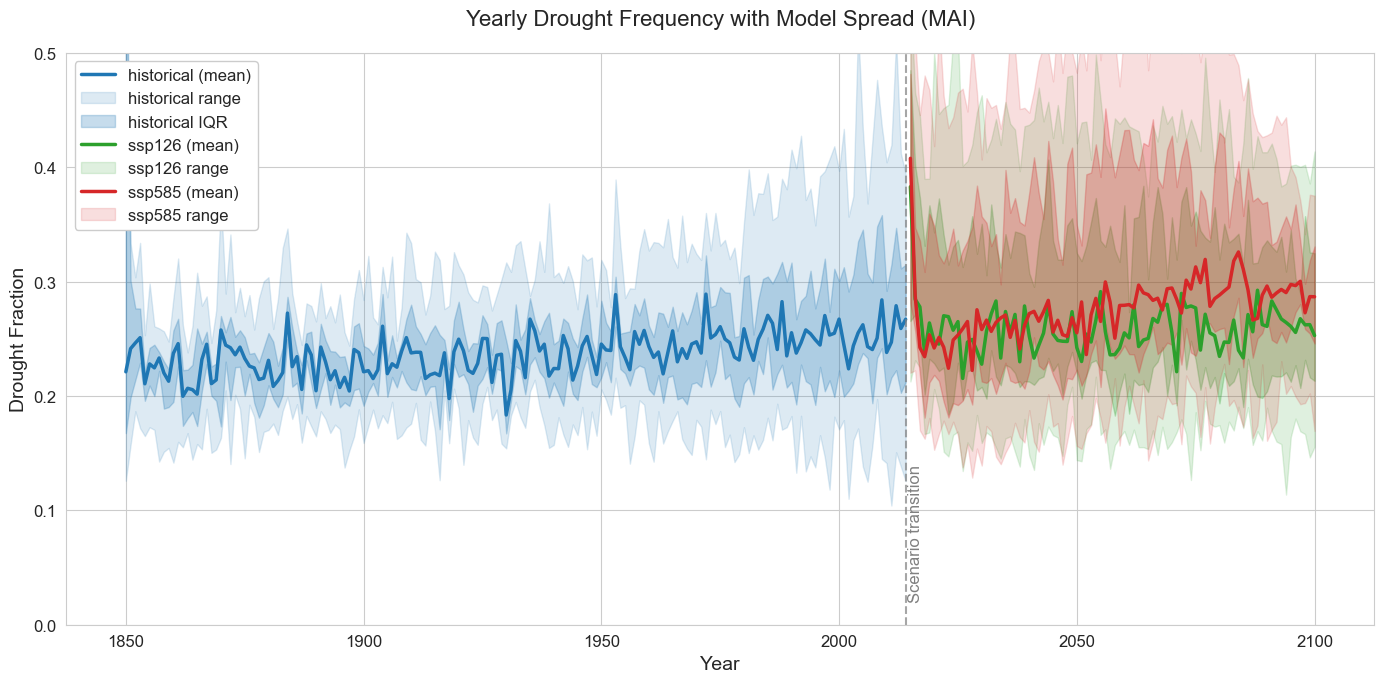

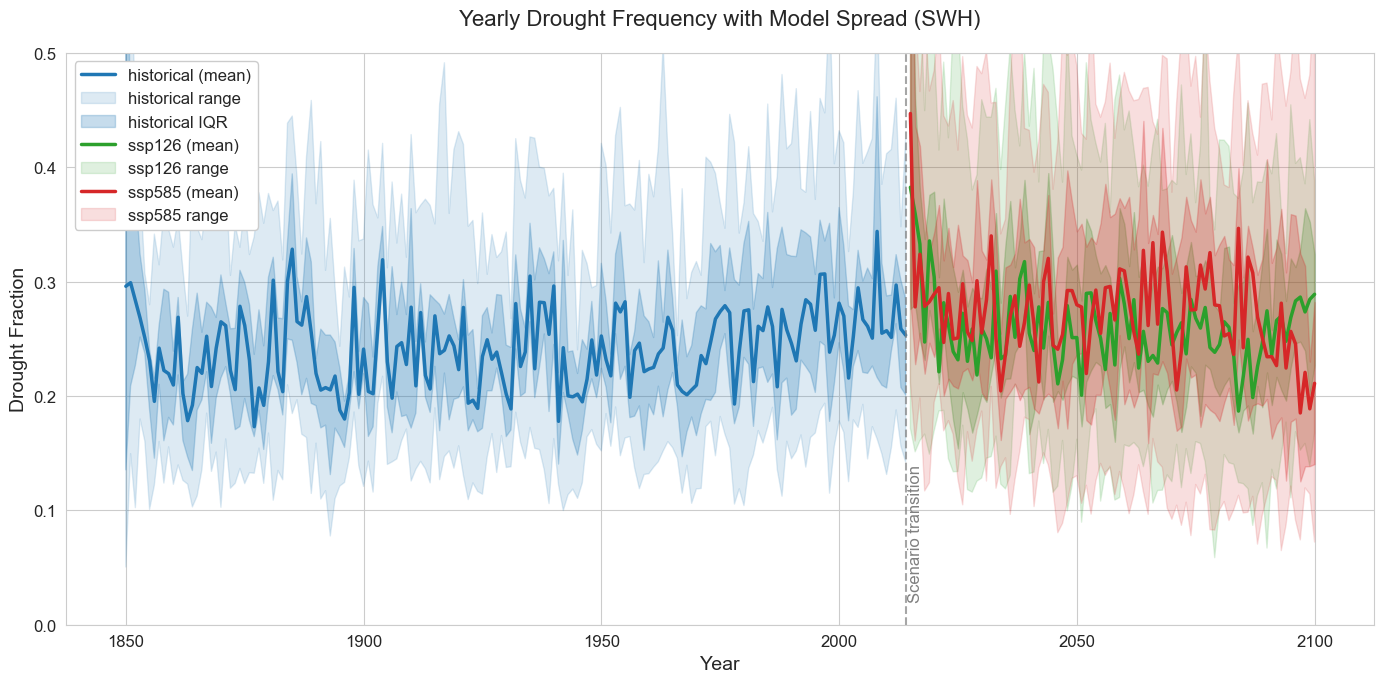

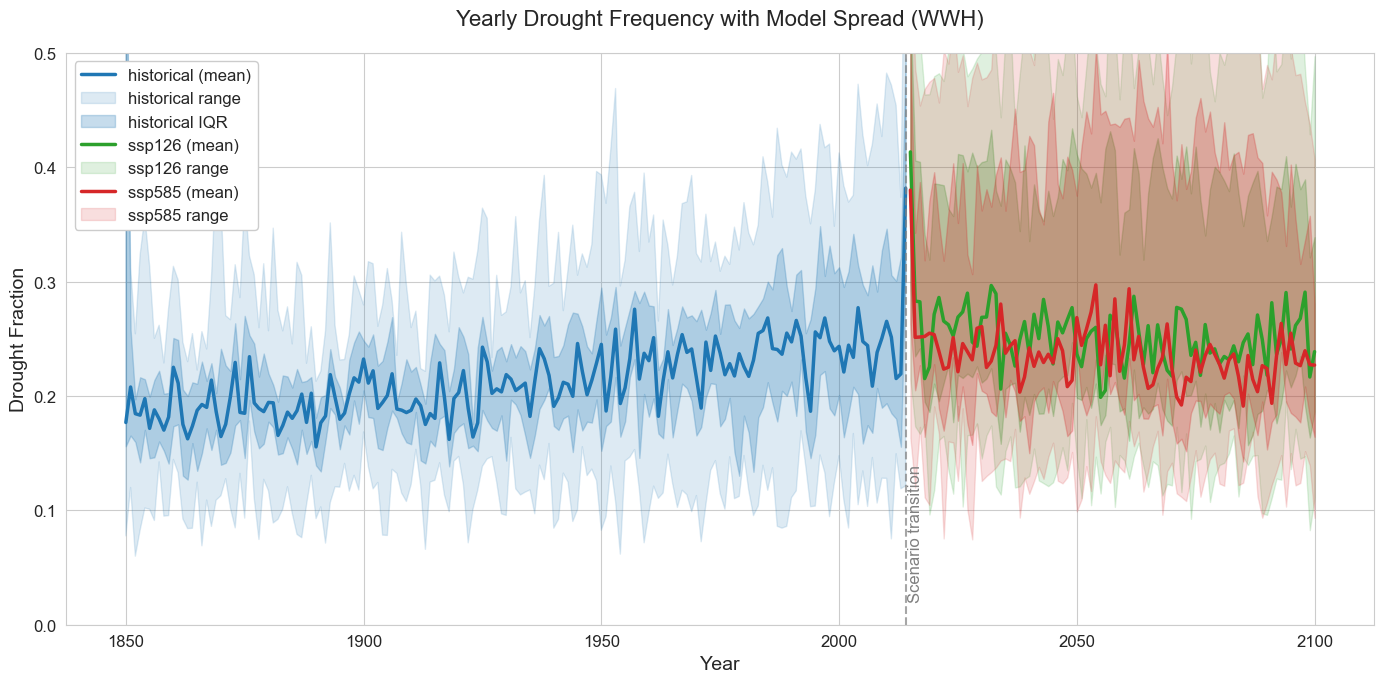

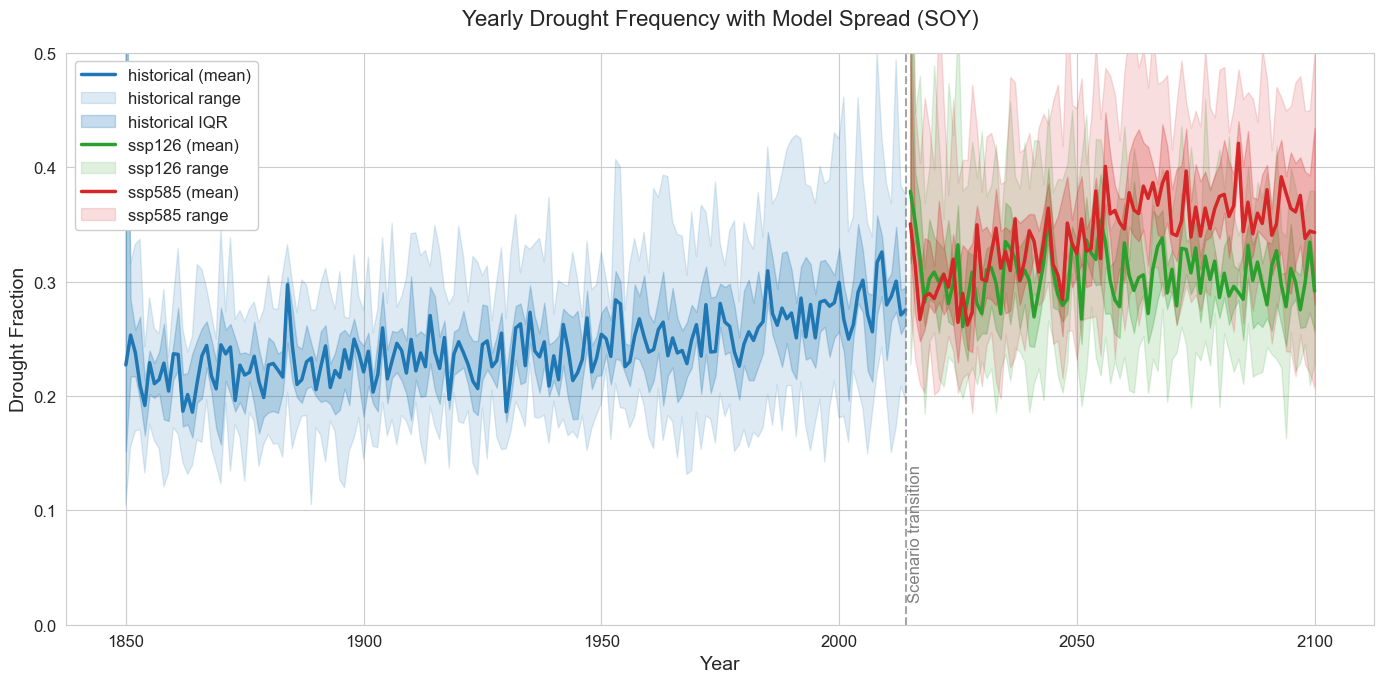

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
crops = ['mai', 'swh', 'wwh', 'soy']
var = 'ssi'
# Set style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

# Define color palette for scenarios
palette = {
    'historical': '#1f77b4',
    'ssp126': '#2ca02c',
    'ssp585': '#d62728'
}

# Create plots for each crop
for crop in crops:
    # Read the results
    df = pd.read_csv(f'D:\\AAUDE\\paper\\paper8\\data\\resu\\{crop}_{var}_scale2_droughtfreq_yearly.csv')
    
    # Calculate statistics for each scenario
    stats_df = df.groupby(['scenario', 'year']).agg(
        mean=('drought_fraction', 'median'),
        min=('drought_fraction', 'min'),
        max=('drought_fraction', 'max'),
        q25=('drought_fraction', lambda x: np.percentile(x, 25)),
        q75=('drought_fraction', lambda x: np.percentile(x, 75))
    ).reset_index()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Plot each scenario with range
    for scenario in ['historical', 'ssp126', 'ssp585']:
        scenario_data = stats_df[stats_df['scenario'] == scenario]
        
        # Plot the mean line
        ax.plot(scenario_data['year'], scenario_data['mean'], 
                color=palette[scenario], linewidth=2.5, 
                label=f'{scenario} (mean)')
        
        # Plot the range (min-max)
        ax.fill_between(scenario_data['year'], 
                        scenario_data['min'], 
                        scenario_data['max'],
                        color=palette[scenario], alpha=0.15,
                        label=f'{scenario} range')
        
        # Plot interquartile range (optional)
        ax.fill_between(scenario_data['year'], 
                        scenario_data['q25'], 
                        scenario_data['q75'],
                        color=palette[scenario], alpha=0.25,
                        label=f'{scenario} IQR' if scenario == 'historical' else "")
    
    # Add details
    ax.set_title(f'Yearly Drought Frequency with Model Spread ({crop.upper()})', pad=20)
    ax.set_xlabel('Year')
    ax.set_ylabel('Drought Fraction')
    ax.set_ylim(0, 0.5)  # Adjust based on your data range
    
    # Add transition line and text
    ax.axvline(x=2014, color='gray', linestyle='--', alpha=0.7)
    ax.text(2014.5, 0.02, 'Scenario transition', rotation=90, 
            va='bottom', ha='left', color='gray')
    
    # Improve legend
    handles, labels = ax.get_legend_handles_labels()
    # Remove duplicate labels
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', framealpha=1)
    
    # Save the figure
    plt.tight_layout()
    # plt.savefig(f'D:\\AAUDE\\paper\\paper8\\data\\resu\\{crop}_drought_frequency_ranges.png', 
    #             dpi=300, bbox_inches='tight')
    plt.show()

<Figure size 1400x800 with 0 Axes>

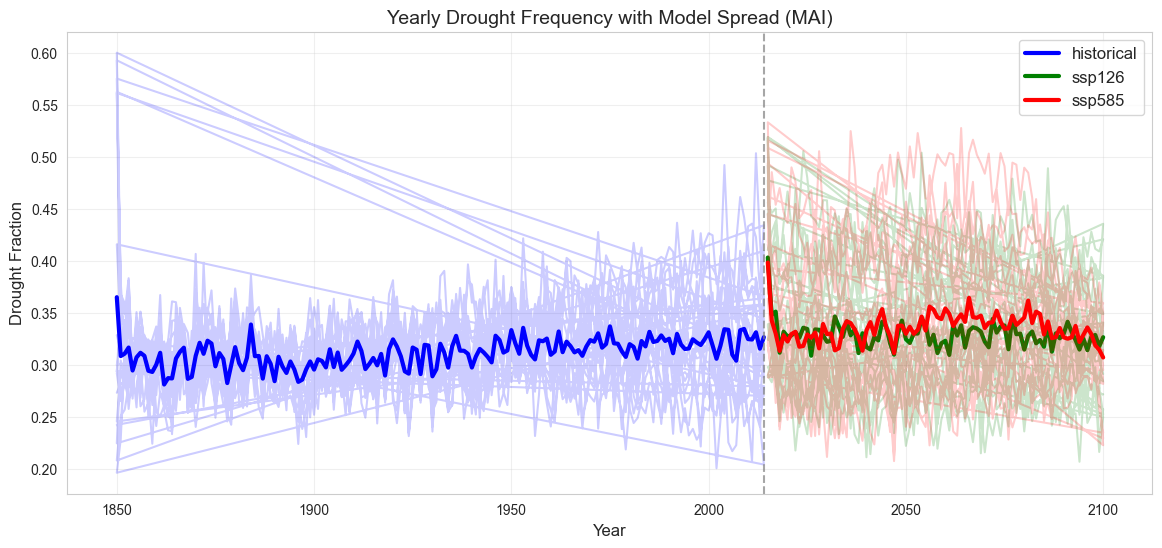

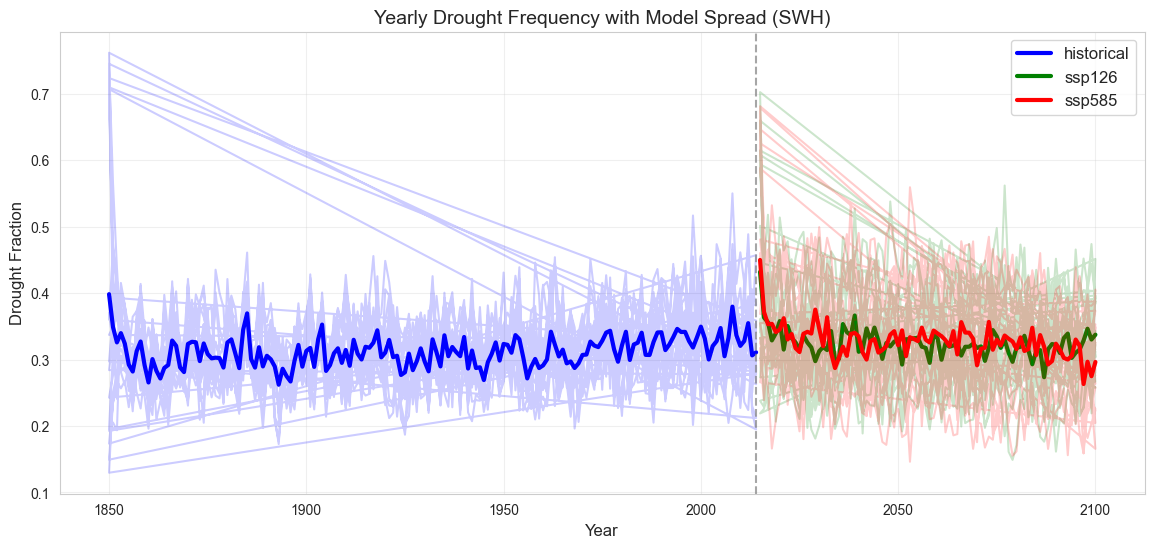

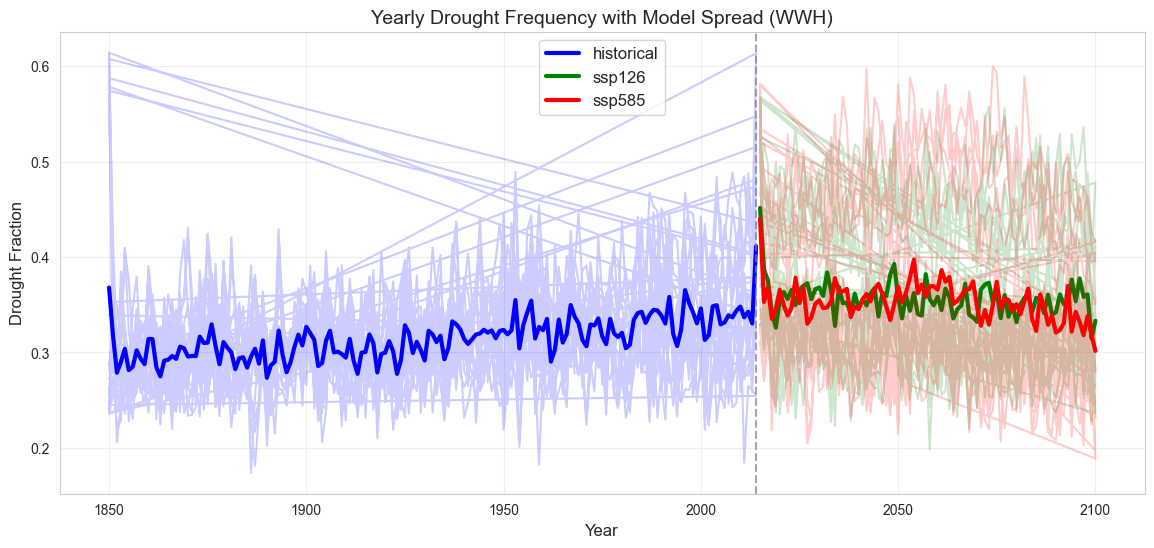

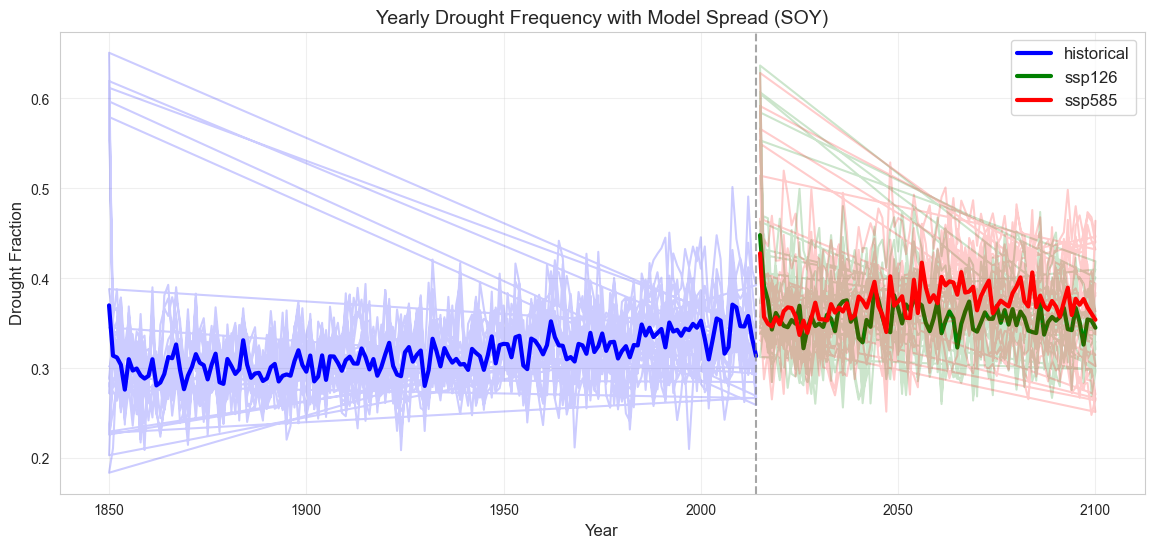

In [6]:
plt.figure(figsize=(14, 8))

for crop in crops:
    df = pd.read_csv(f'D:\\AAUDE\\paper\\paper8\\data\\resu\\{crop}_{var}_scale2_droughtfreq_yearly.csv')
    
    # Create figure with model spread
    plt.figure(figsize=(14, 6))
    
    for scenario in ['historical', 'ssp126', 'ssp585']:
        # Plot individual models
        scenario_data = df[df['scenario'] == scenario]
        for model in scenario_data['model'].unique():
            model_data = scenario_data[scenario_data['model'] == model]
            plt.plot(model_data['year'], model_data['drought_fraction'], 
                     color=palette[scenario], alpha=0.2)
        
        # Plot multi-model mean
        mean_data = scenario_data.groupby('year').mean(numeric_only=True).reset_index()
        plt.plot(mean_data['year'], mean_data['drought_fraction'], 
                 color=palette[scenario], linewidth=3, label=scenario)
    
    plt.title(f'Yearly Drought Frequency with Model Spread ({crop.upper()})', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Drought Fraction', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axvline(x=2014, color='gray', linestyle='--', alpha=0.7)
    
    # plt.savefig(f'D:\\AAUDE\\paper\\paper8\\data\\resu\\{crop}_drought_frequency_with_spread.png', 
    #             dpi=300, bbox_inches='tight')
    plt.show()

### CO2

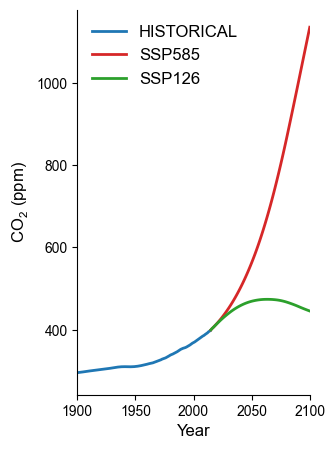

In [26]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
fp = r'F:\迅雷下载'
files =os.listdir(fp)

plt.figure(figsize=(3, 5))
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
# plt.rcParams["font.family"] = "Arial"
colors = {
    'historical': '#1f77b4',
    'ssp126': '#2ca02c',
    'ssp585': '#d62728'
}

for file in files:
    scenario = file.split('_')[1]
    df = pd.read_csv(os.path.join(fp, file),sep='\s+', header=None, names=['Year', 'CO2'])
    plt.plot(df['Year'], df['CO2'], label=scenario.upper(), color=colors[scenario],linewidth=2)

plt.xlabel('Year', fontsize=12)
plt.ylabel('CO$_2$ (ppm)', fontsize=12)
# plt.grid(True, alpha=0.3)
plt.legend(frameon=False,fontsize=12)
plt.xlim(1900, 2100)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.tight_layout()
plt.show()

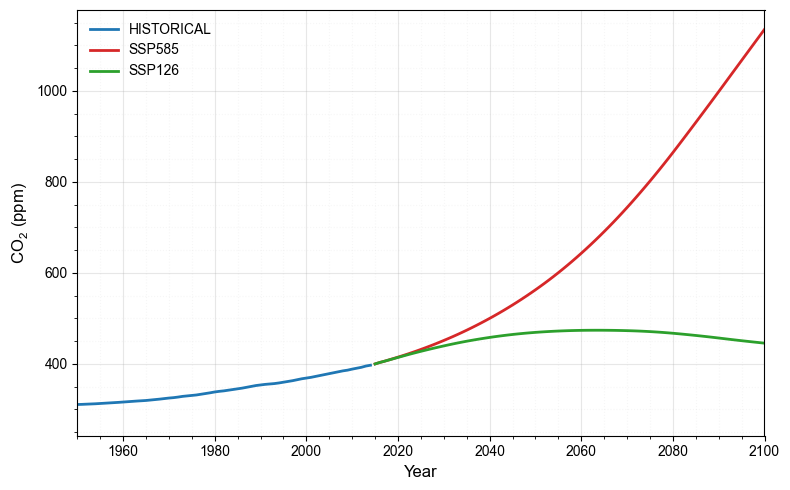

In [19]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

fp = r'F:\迅雷下载'
files = os.listdir(fp)

# Set up figure with better proportions
plt.figure(figsize=(8, 5))  # Wider figure for better readability
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

# Use a font that definitely has the subscript 2 character
try:
    plt.rcParams["mathtext.fontset"] = "custom"
    plt.rcParams["mathtext.rm"] = "Arial"
    plt.rcParams["mathtext.it"] = "Arial:italic"
except:
    pass  # Fall back to default if customization fails

colors = {
    'historical': '#1f77b4',
    'ssp126': '#2ca02c',
    'ssp585': '#d62728'
}

for file in files:
    if not file.endswith('.txt'):
        continue  # Skip non-text files
        
    scenario = file.split('_')[1]
    df = pd.read_csv(os.path.join(fp, file), sep='\s+', header=None, names=['Year', 'CO2'])
    plt.plot(df['Year'], df['CO2'], label=scenario.upper(), color=colors[scenario], linewidth=2)

# Use regular "2" if subscript causes problems
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO$_2$ (ppm)', fontsize=12)  # Using math text for subscript

plt.legend(fontsize=10, frameon=False)  # Cleaner legend without box
plt.xlim(1950, 2100)

# Add minor grid lines for better readability
plt.grid(True, which='major', linestyle='-', alpha=0.3)
plt.grid(True, which='minor', linestyle=':', alpha=0.1)
plt.minorticks_on()

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

### tas

In [9]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from os.path import join
from tqdm.notebook import tqdm

# === 参数设置 ===
crops = ['mai', 'wwh', 'soy']
ssps = ['historical', 'ssp126', 'ssp585']
base_path = Path(r'E:\isimip3b_agricultal')
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
out_dir.mkdir(exist_ok=True)
for ssp in ssps:
    all_series = []
    for ggcm in os.listdir(r'E:\water_phase_3b'):
    # for crop in crops:
    #     area_path = join(r'D:\AAUDE\paper\paper8\data\area', f'spam2020_v1r0_global_H_{crop}_R.nc')
    #     area = xr.open_dataset(area_path)[list(xr.open_dataset(area_path).data_vars)[0]]
        if ssp == 'historical':
            years = np.arange(1900, 2015)
        else:
            years = np.arange(2015, 2101)
        maty=xr.open_dataset(join(r'E:\water_phase_3b',ggcm,ssp,'Tavg_annualavg.nc'), decode_times=False)
        swd = maty[f'Tavg_annualavg']
        swd=swd.where(~np.isinf(swd), np.nan)
        swd_median = swd.mean(dim=['lat', 'lon'])
        swd_median['time'] = years
    
        series = swd_median.to_series().reset_index(drop=True)
        all_series.append(series)
    
        result_df = pd.DataFrame(all_series).T
        result_df.columns = [f'model_{i+1}' for i in range(len(all_series))]
        result_df['year'] = years
        result_df = result_df.set_index('year')
        result_df.to_csv(out_dir / f'tas_{ssp}.csv')

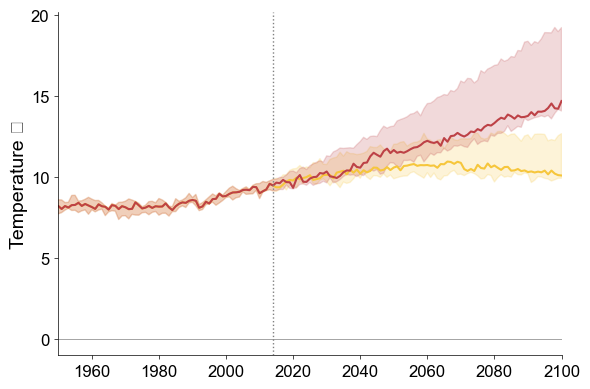

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import matplotlib.ticker as mticker

out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
crop = 'mai'

# 读取数据
hist = pd.read_csv(out_dir / f'tas_historical.csv', index_col='year')
ssp126 = pd.read_csv(out_dir / f'tas_ssp126.csv', index_col='year')
ssp585 = pd.read_csv(out_dir / f'tas_ssp585.csv', index_col='year')

# 合并default的历史 + 未来
default_all_126 = pd.concat([hist, ssp126])
default_all_585 = pd.concat([hist, ssp585])

plt.figure(figsize=(6, 4))

def plot_with_iqr(df, label, color, linestyle='-'):
    years = df.index
    median = df.median(axis=1)
    q25 = df.quantile(0.25, axis=1)
    q75 = df.quantile(0.75, axis=1)
    
    plt.plot(years, median, label=label, color=color, linestyle=linestyle)
    plt.fill_between(years, df.min(axis=1), df.max(axis=1), color=color, alpha=0.2)

# 绘制距平图
plot_with_iqr(default_all_126, 'SSP126', color='#F6C63C')
plot_with_iqr(default_all_585, 'SSP585', color='#BD4146')
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.set_xlim(1950, 2100)  # 调整范围避免边缘空白
ax.set_ylabel('Temperature ℃', fontsize=14, labelpad=2)
ax.set_xlabel('', fontsize=9, labelpad=2)

# 刻度设置（主刻度50年，次刻度10年）
ax.xaxis.set_major_locator(mticker.MultipleLocator(20))
ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
ax.tick_params(axis='both', which='major', width=0.5, length=3, labelsize=12)

# 辅助设置
plt.axvline(x=2014, linestyle=':', color='gray', linewidth=1)
plt.axhline(y=0, linestyle='-', color='gray', linewidth=0.5) 

plt.tight_layout()
plt.show()

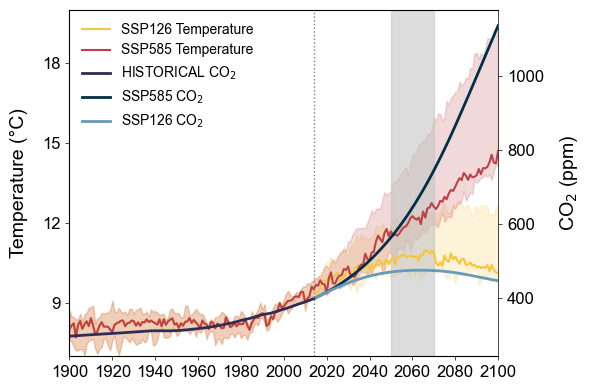

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import matplotlib.ticker as mticker
import os
import numpy as np

# Set global styles
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

# Create figure with two subplots sharing the x-axis
fig, ax1 = plt.subplots(figsize=(6, 4))

# ====== First Plot (Temperature) ======
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
crop = 'mai'

# Read temperature data
hist = pd.read_csv(out_dir / f'tas_historical.csv', index_col='year')
ssp126 = pd.read_csv(out_dir / f'tas_ssp126.csv', index_col='year')
ssp585 = pd.read_csv(out_dir / f'tas_ssp585.csv', index_col='year')

# Combine historical + future
default_all_126 = pd.concat([hist, ssp126])
default_all_585 = pd.concat([hist, ssp585])

def plot_with_iqr(df, label, color, linestyle='-'):
    years = df.index
    median = df.median(axis=1)
    q25 = df.quantile(0.25, axis=1)
    q75 = df.quantile(0.75, axis=1)
    
    ax1.plot(years, median, label=label, color=color, linestyle=linestyle)
    ax1.fill_between(years, df.min(axis=1), df.max(axis=1), color=color, alpha=0.2)

# Plot temperature data on primary axis (left)
plot_with_iqr(default_all_126, 'SSP126 Temperature', color='#F6C63C')
plot_with_iqr(default_all_585, 'SSP585 Temperature', color='#BD4146')
ax1.axvspan(2050, 2070, color='#C5C5C5', alpha=0.6, label='')
# Format primary axis
ax1.set_xlim(1900, 2100)
ax1.set_ylabel('Temperature (°C)', fontsize=14, labelpad=10)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_linewidth(0.5)
ax1.spines['bottom'].set_linewidth(0.5)
ax1.xaxis.set_major_locator(mticker.MultipleLocator(20))
ax1.yaxis.set_major_locator(mticker.MaxNLocator(5))
ax1.tick_params(axis='both', which='major', width=0.5, length=3, labelsize=12)
ax1.set_ylim(7,20)

# Add reference lines
ax1.axvline(x=2014, linestyle=':', color='gray', linewidth=1)
ax1.axhline(y=0, linestyle='-', color='gray', linewidth=0.5)

# ====== Second Plot (CO2) ======
# ====== Second Plot (CO2) ======
ax2 = ax1.twinx()  # Create secondary y-axis

fp = r'F:\迅雷下载'
files = os.listdir(fp)

colors = {
    'historical': '#2F2D54',
    'ssp126': '#669ABA',
    'ssp585': '#012F48'
}

# 先绘制填充区域（面积图）
# for file in files:
#     if not file.endswith('.txt'):
#         continue
        
#     scenario = file.split('_')[1]
#     df = pd.read_csv(os.path.join(fp, file), sep='\s+', header=None, names=['Year', 'CO2'])
    
#     # 绘制填充区域（alpha设为0.3）
#     ax2.fill_between(df['Year'], 0, df['CO2'], 
#                     color=colors[scenario], alpha=0.3, label='_nolegend_')

# 再绘制折线（保持原样）
for file in files:
    if not file.endswith('.txt'):
        continue
        
    scenario = file.split('_')[1]
    df = pd.read_csv(os.path.join(fp, file), sep='\s+', header=None, names=['Year', 'CO2'])
    ax2.plot(df['Year'], df['CO2'], label=f'{scenario.upper()} CO$_2$', 
             color=colors[scenario], linewidth=2, linestyle='-')

# Format secondary axis
ax2.set_ylabel('CO$_2$ (ppm)', fontsize=14, labelpad=10)
ax2.spines['right'].set_linewidth(0.5)
ax2.yaxis.set_major_locator(mticker.MaxNLocator(5))
ax2.tick_params(axis='y', which='major', width=0.5, length=3, labelsize=12)
# ax2.set_ylim(bottom=0)  # 确保填充从0开始
# ax1.set_ylim(7,20)
# 其他部分保持不变...

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
           frameon=False, fontsize=10, loc='upper left')

plt.tight_layout()
out_dir = Path(r'D:\AAUDE\paper\paper8\data\swdd_series')
plt.savefig(out_dir / f'CO2.pdf', dpi=300, bbox_inches='tight')
plt.show()